<a href="https://colab.research.google.com/github/WebberMark02/machine-learning-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto di "Introduzione all'apprendimento automatico" di febbraio 2025
Daniele Russo  
Matricola: 0001028215  
Data: 10 febbraio 2025

---



Importo le librerie necessarie e scelgo "tensorflow" come back-end per "Keras".

In [2]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from matplotlib import pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist

Imposto le variabili globali.

In [4]:
seed = 23894234
training_set_size = 1001000
testing_set_size = 5000
validation_set_size = 429000
image_shape = (32, 32, 1)
batch_size = 256
epochs = 250
learning_rate = 0.0001

# Numero minimo di epoche da attendere prima di fermare l'addestramento.
early_stopping_patience = 50

# Numero minimo di epoche da attendere prima di ridurre il learning rate.
reduce_lr_patience = 5

minimum_lr = 1e-7
training_backup_path = './daniele-russo-0001028215-ml-february-2025-trainingbackup/'
net_parameters_path = './daniele-russo-0001028215-ml-february-2025-network.weights.h5'

Imposto il seed per la riproducibilità.
Ciò mi ha permesso di confrontare le prestazioni ottenute da diversi addestramenti per scegliere dei buoni valori da assegnare agli iper-parametri.

In [5]:
# Ciò imposta:
# 1) il seed di `numpy`
# 2) il seed per il generatore di numeri pseudo-casuali del backend (in questo caso, `tensorflow`)
# 3) il seed per i generatori di numeri pseudo-casuali di `python`
keras.utils.set_random_seed(seed)

Definisco il generatore di immagini sulle quali il modello
verrà addestrato e testato.  
Il generatore restituisce "batchsize" immagini; ogni immagine è
la media di due immagini scelte casualmente rispettivamente da 'x1' e 'x2'.  
Il generatore restituisce, inoltre, per ogni media di immagini, la coppia delle immagini delle quali è stata calcolata la media stessa.

In [6]:
def datagenerator(x1, x2, batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Definisco una funzione per il controllo del bilanciamento delle classi.  
Mi servirà per verificare che la divisione stratificata abbia avuto successo.

In [7]:
def stampa_percentuale(y, title = ""):
  if title:
    print(title)
  # Calcolo le occorrenze di ciascuna classe nel dataset.
  unique, counts = np.unique(y, return_counts = True)
  # Calcolo la % di occorrenze per ciascuna classe.
  percentuali = (counts / len(y)) * 100
  # Stampo le occorrenze e le percentuali.
  for classe, conteggio, percentuale in zip(unique, counts, percentuali):
      print(f"Classe {classe}: Occorrenze = {conteggio}, Percentuale {percentuale} %" )
  print(f"Totale occorrenze : {sum(counts)}")
  print()

Definisco un modello banale.
Mi servirà per valutare che la rete abbia prestazioni migliori di esso.

In [8]:
def ide_model(x):
   return((x,x))

Ora ha inizio la fase di caricamento e preparazione dei dataset che verranno utilizzati
per addestrare e esaminare le prestazioni della rete.

Prima di tutto, carico i training set e i testing set di "MNIST" e "Fashion MNIST".

In [9]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

print(np.shape(mnist_x_train))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)


Ridimensiono le immagini tramite padding, portando la loro risoluzione da 28x28 a 32x32.  
Inoltre, le normalizzo nell'intervallo [0, 1].

In [10]:
#normalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

print(np.shape(mnist_x_train))

(60000, 32, 32)


Aggiungo una dimensione agli array numpy delle immagini (non modifico affatto
le immagini).  
Mi serve per rendere le immagini compatibili con le dimensioni
del layer di input della rete neurale.

In [11]:
print(np.shape(mnist_x_train))
print(np.shape(mnist_x_test))
print(np.shape(fashion_mnist_x_train))
print(np.shape(fashion_mnist_x_test))

mnist_x_train = np.reshape(mnist_x_train, (mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2], 1))
mnist_x_test = np.reshape(mnist_x_test, (mnist_x_test.shape[0], mnist_x_test.shape[1], mnist_x_test.shape[2], 1))
fashion_mnist_x_train = np.reshape(fashion_mnist_x_train, (fashion_mnist_x_train.shape[0], fashion_mnist_x_train.shape[1], fashion_mnist_x_train.shape[2], 1))
fashion_mnist_x_test = np.reshape(fashion_mnist_x_test, (fashion_mnist_x_test.shape[0], fashion_mnist_x_test.shape[1], fashion_mnist_x_test.shape[2], 1))

print(np.shape(mnist_x_train))
print(np.shape(mnist_x_test))
print(np.shape(fashion_mnist_x_train))
print(np.shape(fashion_mnist_x_test))

(60000, 32, 32)
(10000, 32, 32)
(60000, 32, 32)
(10000, 32, 32)
(60000, 32, 32, 1)
(10000, 32, 32, 1)
(60000, 32, 32, 1)
(10000, 32, 32, 1)


Visualizzo qualche immagine per accertarmi che l'operazione di reshaping non le abbia modificate.

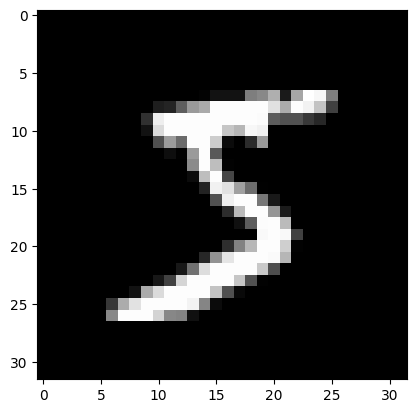

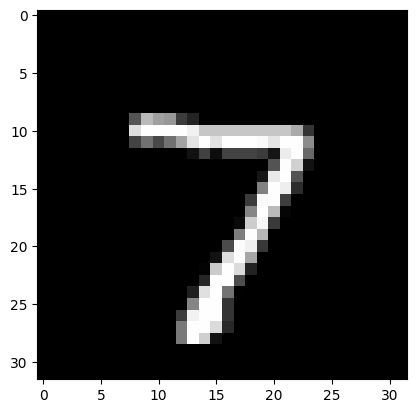

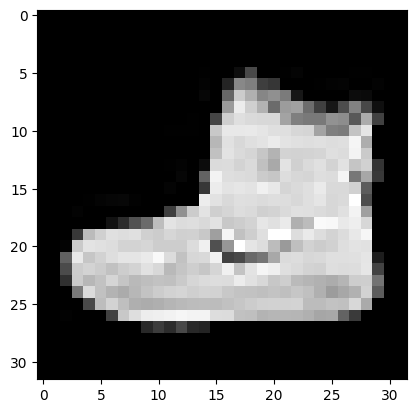

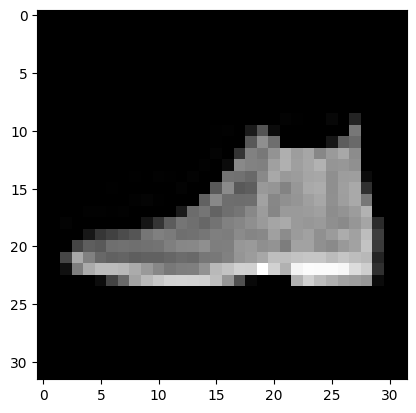

(32, 32, 1)


In [12]:
plt.imshow(mnist_x_train[0], cmap='gray')
plt.show()
plt.imshow(mnist_x_test[0], cmap='gray')
plt.show()
plt.imshow(fashion_mnist_x_train[0], cmap='gray')
plt.show()
plt.imshow(fashion_mnist_x_test[0], cmap='gray')
plt.show()

print(mnist_x_train[0].shape)

Controllo il bilanciamento delle classi nei training set prima della divisione stratificata.

In [13]:
stampa_percentuale(mnist_y_train, 'MNIST training set completo')
stampa_percentuale(fashion_mnist_y_train, 'Fashion MNIST training set completo')

MNIST training set completo
Classe 0: Occorrenze = 5923, Percentuale 9.871666666666666 %
Classe 1: Occorrenze = 6742, Percentuale 11.236666666666666 %
Classe 2: Occorrenze = 5958, Percentuale 9.93 %
Classe 3: Occorrenze = 6131, Percentuale 10.218333333333334 %
Classe 4: Occorrenze = 5842, Percentuale 9.736666666666666 %
Classe 5: Occorrenze = 5421, Percentuale 9.035 %
Classe 6: Occorrenze = 5918, Percentuale 9.863333333333333 %
Classe 7: Occorrenze = 6265, Percentuale 10.441666666666666 %
Classe 8: Occorrenze = 5851, Percentuale 9.751666666666667 %
Classe 9: Occorrenze = 5949, Percentuale 9.915000000000001 %
Totale occorrenze : 60000

Fashion MNIST training set completo
Classe 0: Occorrenze = 6000, Percentuale 10.0 %
Classe 1: Occorrenze = 6000, Percentuale 10.0 %
Classe 2: Occorrenze = 6000, Percentuale 10.0 %
Classe 3: Occorrenze = 6000, Percentuale 10.0 %
Classe 4: Occorrenze = 6000, Percentuale 10.0 %
Classe 5: Occorrenze = 6000, Percentuale 10.0 %
Classe 6: Occorrenze = 6000, Perc

Divido ogni training set in due insiemi: il training set e il validation set.
Le immagini dei validation set verranno usate per l'ottimizzazione degli iper-parametri della rete.
Ogni validation set conterrà il 30% delle immagini del training set di partenza.
Uso la stratificazione per mantenere le classi nelle stesse proporzioni.

In [14]:
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = sklearn.model_selection.train_test_split(mnist_x_train, mnist_y_train, test_size=0.3, stratify=mnist_y_train, random_state=seed)
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = sklearn.model_selection.train_test_split(fashion_mnist_x_train, fashion_mnist_y_train, test_size=0.3, stratify=fashion_mnist_y_train, random_state=seed)

Controllo il bilanciamento delle classi nei training set e nei validation set ottenuti dalla divisione stratificata.

In [15]:
stampa_percentuale(mnist_y_train, 'MNIST training set risultante')
stampa_percentuale(mnist_y_val, 'MNIST validation set risultante')

stampa_percentuale(fashion_mnist_y_train, 'Fashion MNIST training set risultante')
stampa_percentuale(fashion_mnist_y_val, 'Fashion MNIST validation set risultante')

MNIST training set risultante
Classe 0: Occorrenze = 4146, Percentuale 9.871428571428572 %
Classe 1: Occorrenze = 4719, Percentuale 11.235714285714286 %
Classe 2: Occorrenze = 4171, Percentuale 9.93095238095238 %
Classe 3: Occorrenze = 4292, Percentuale 10.21904761904762 %
Classe 4: Occorrenze = 4089, Percentuale 9.735714285714286 %
Classe 5: Occorrenze = 3795, Percentuale 9.035714285714286 %
Classe 6: Occorrenze = 4143, Percentuale 9.864285714285714 %
Classe 7: Occorrenze = 4385, Percentuale 10.44047619047619 %
Classe 8: Occorrenze = 4096, Percentuale 9.752380952380953 %
Classe 9: Occorrenze = 4164, Percentuale 9.914285714285715 %
Totale occorrenze : 42000

MNIST validation set risultante
Classe 0: Occorrenze = 1777, Percentuale 9.872222222222222 %
Classe 1: Occorrenze = 2023, Percentuale 11.238888888888889 %
Classe 2: Occorrenze = 1787, Percentuale 9.927777777777779 %
Classe 3: Occorrenze = 1839, Percentuale 10.216666666666667 %
Classe 4: Occorrenze = 1753, Percentuale 9.738888888888

Creo tre istanze del generatore per generare il training set, il validation set e il testing set finali.

In [16]:
traingen = datagenerator(mnist_x_train, fashion_mnist_x_train, training_set_size)
valgen = datagenerator(mnist_x_val, fashion_mnist_x_val, validation_set_size)
testgen = datagenerator(mnist_x_test, fashion_mnist_x_test, testing_set_size)

Creo il training set e il validation set.

In [17]:
x_train, y_train = next(traingen)
x_val, y_val = next(valgen)

Verifico che le dimensioni dei due dataset siano corrette.

In [18]:
print(x_train.shape)
print(x_val.shape)

print(len(y_train))
print(len(y_val))

print(y_train[0].shape)
print(y_train[1].shape)
print(y_val[0].shape)
print(y_val[1].shape)

(1001000, 32, 32, 1)
(429000, 32, 32, 1)
2
2
(1001000, 32, 32, 1)
(1001000, 32, 32, 1)
(429000, 32, 32, 1)
(429000, 32, 32, 1)


Controllo che i valori dei pixel delle immagini appartengano all'intervallo [0,1].

In [19]:
print(np.min(x_train[0]), np.max(x_train[0]))
print(np.min(x_val[0]), np.max(x_val[0]))

0.0 0.9823529411764707
0.0 0.9176470588235295


Mostro qualche immagine dei due dataset.

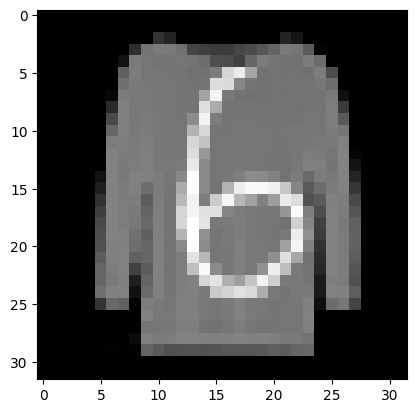

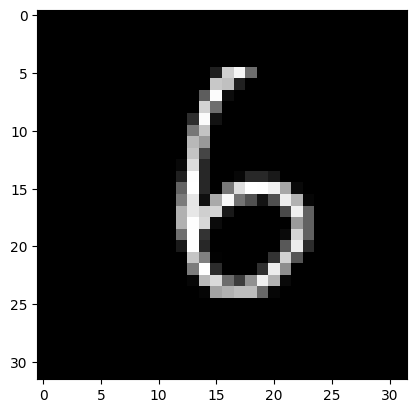

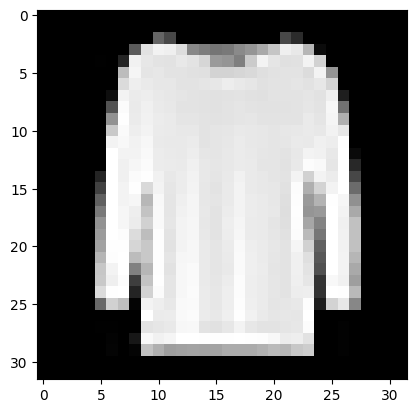

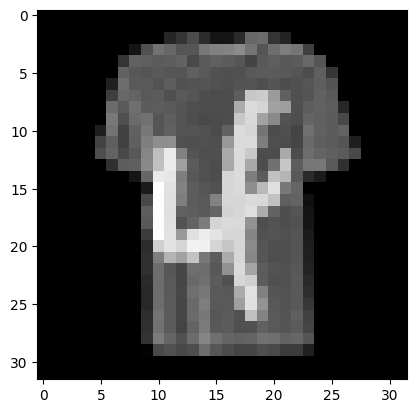

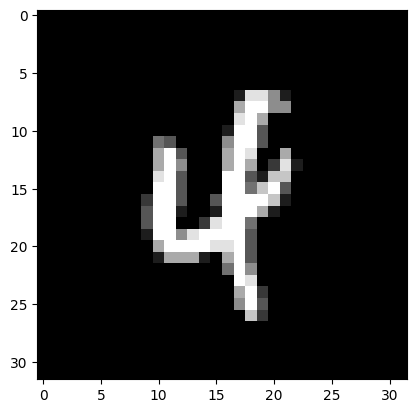

(32, 32, 1)


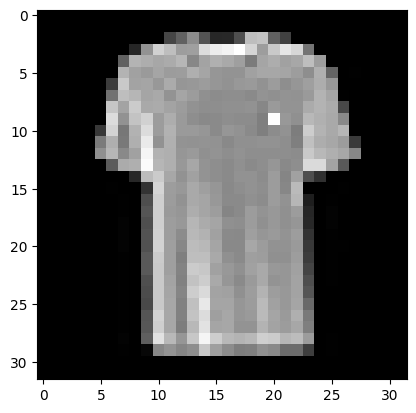

In [20]:
plt.imshow(x_train[0], cmap='gray')
plt.show()
plt.imshow(y_train[0][0], cmap='gray')
plt.show()
plt.imshow(y_train[1][0], cmap='gray')
plt.show()
plt.imshow(x_val[0], cmap='gray')
plt.show()
plt.imshow(y_val[0][0], cmap='gray')
plt.show()
plt.imshow(y_val[1][0], cmap='gray')

print(x_train[0].shape)

La fase di preparazione dei dataset è completa.
Ora viene definita e compilata la rete neurale.  
    
Essa è formata da due U-Net che condividono lo stesso layer di input.  
Ogni U-Net restituisce una delle due immagini la cui media è l'immagine di partenza, ricostruendola il più fedelmente possibile.   
  
Nei layer convoluzionali, ho impostato il parametro "padding" a "same" per garantire che le dimensioni dei due layer di output siano uguali a quelle del layer di input.  
  
(Inizialmente, avevo provato a utilizzare due semplici autoencoder, ma con essi ottenevo delle prestazioni leggermente peggiori).

In [21]:
def down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    conv = keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    up = keras.layers.UpSampling2D(size=(2, 2))(inputs)
    concat = keras.layers.Concatenate()([up, skip])
    conv = keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat)
    conv = keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv

def build_neural_network():
    # Input Layer UNET 1
    inputs = keras.Input(shape = image_shape, name = 'InputImage')

    #Down Blocks UNET1
    unet1_conv1, unet1_pool1 = down_block(inputs, 64)
    unet1_conv2, unet1_pool2 = down_block(unet1_pool1, 128)
    unet1_conv3, unet1_pool3 = down_block(unet1_pool2, 256)

    # Bottleneck UNET1
    unet1_conv4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(unet1_pool3)
    unet1_conv4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(unet1_conv4)

    #Up Blocks UNET1
    unet1_conv5 = up_block(unet1_conv4, unet1_conv3, 256)
    unet1_conv6 = up_block(unet1_conv5, unet1_conv2, 128)
    unet1_conv7 = up_block(unet1_conv6, unet1_conv1, 64)

    unet1_output = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name = 'MNIST_Image')(unet1_conv7)



    #Down Blocks UNET2
    unet2_conv1, unet2_pool1 = down_block(inputs, 64)
    unet2_conv2, unet2_pool2 = down_block(unet2_pool1, 128)
    unet2_conv3, unet2_pool3 = down_block(unet2_pool2, 256)

    # Bottleneck UNET2
    unet2_conv4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(unet2_pool3)
    unet2_conv4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(unet2_conv4)

    #Up Blocks UNET2
    unet2_conv5 = up_block(unet2_conv4, unet2_conv3, 256)
    unet2_conv6 = up_block(unet2_conv5, unet2_conv2, 128)
    unet2_conv7 = up_block(unet2_conv6, unet2_conv1, 64)

    unet2_output = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name = 'Fashion_MNIST_Image')(unet2_conv7)

    model = keras.Model(inputs = inputs, outputs = [unet1_output, unet2_output], name = 'MNIST_Reconstruction_Model')
    return model

Istanzio la rete e mostro i suoi dettagli.

In [22]:
model = build_neural_network()
model.summary()

Model: "MNIST_Reconstruction_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputImage (InputLayer)   │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ InputImage[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 32, 32, 64)     │            640 │ InputImage[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 64)     │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 8, 8, 128)      │              0 │ conv2d_17[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 256)      │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 8, 8, 256)      │        590,080 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 15,564,546 (59.37 MB)

 Trainable params: 15,564,546 (59.37 MB)

 Non-trainable params: 0 (0.00 B)

Visualizzo un plot della rete.

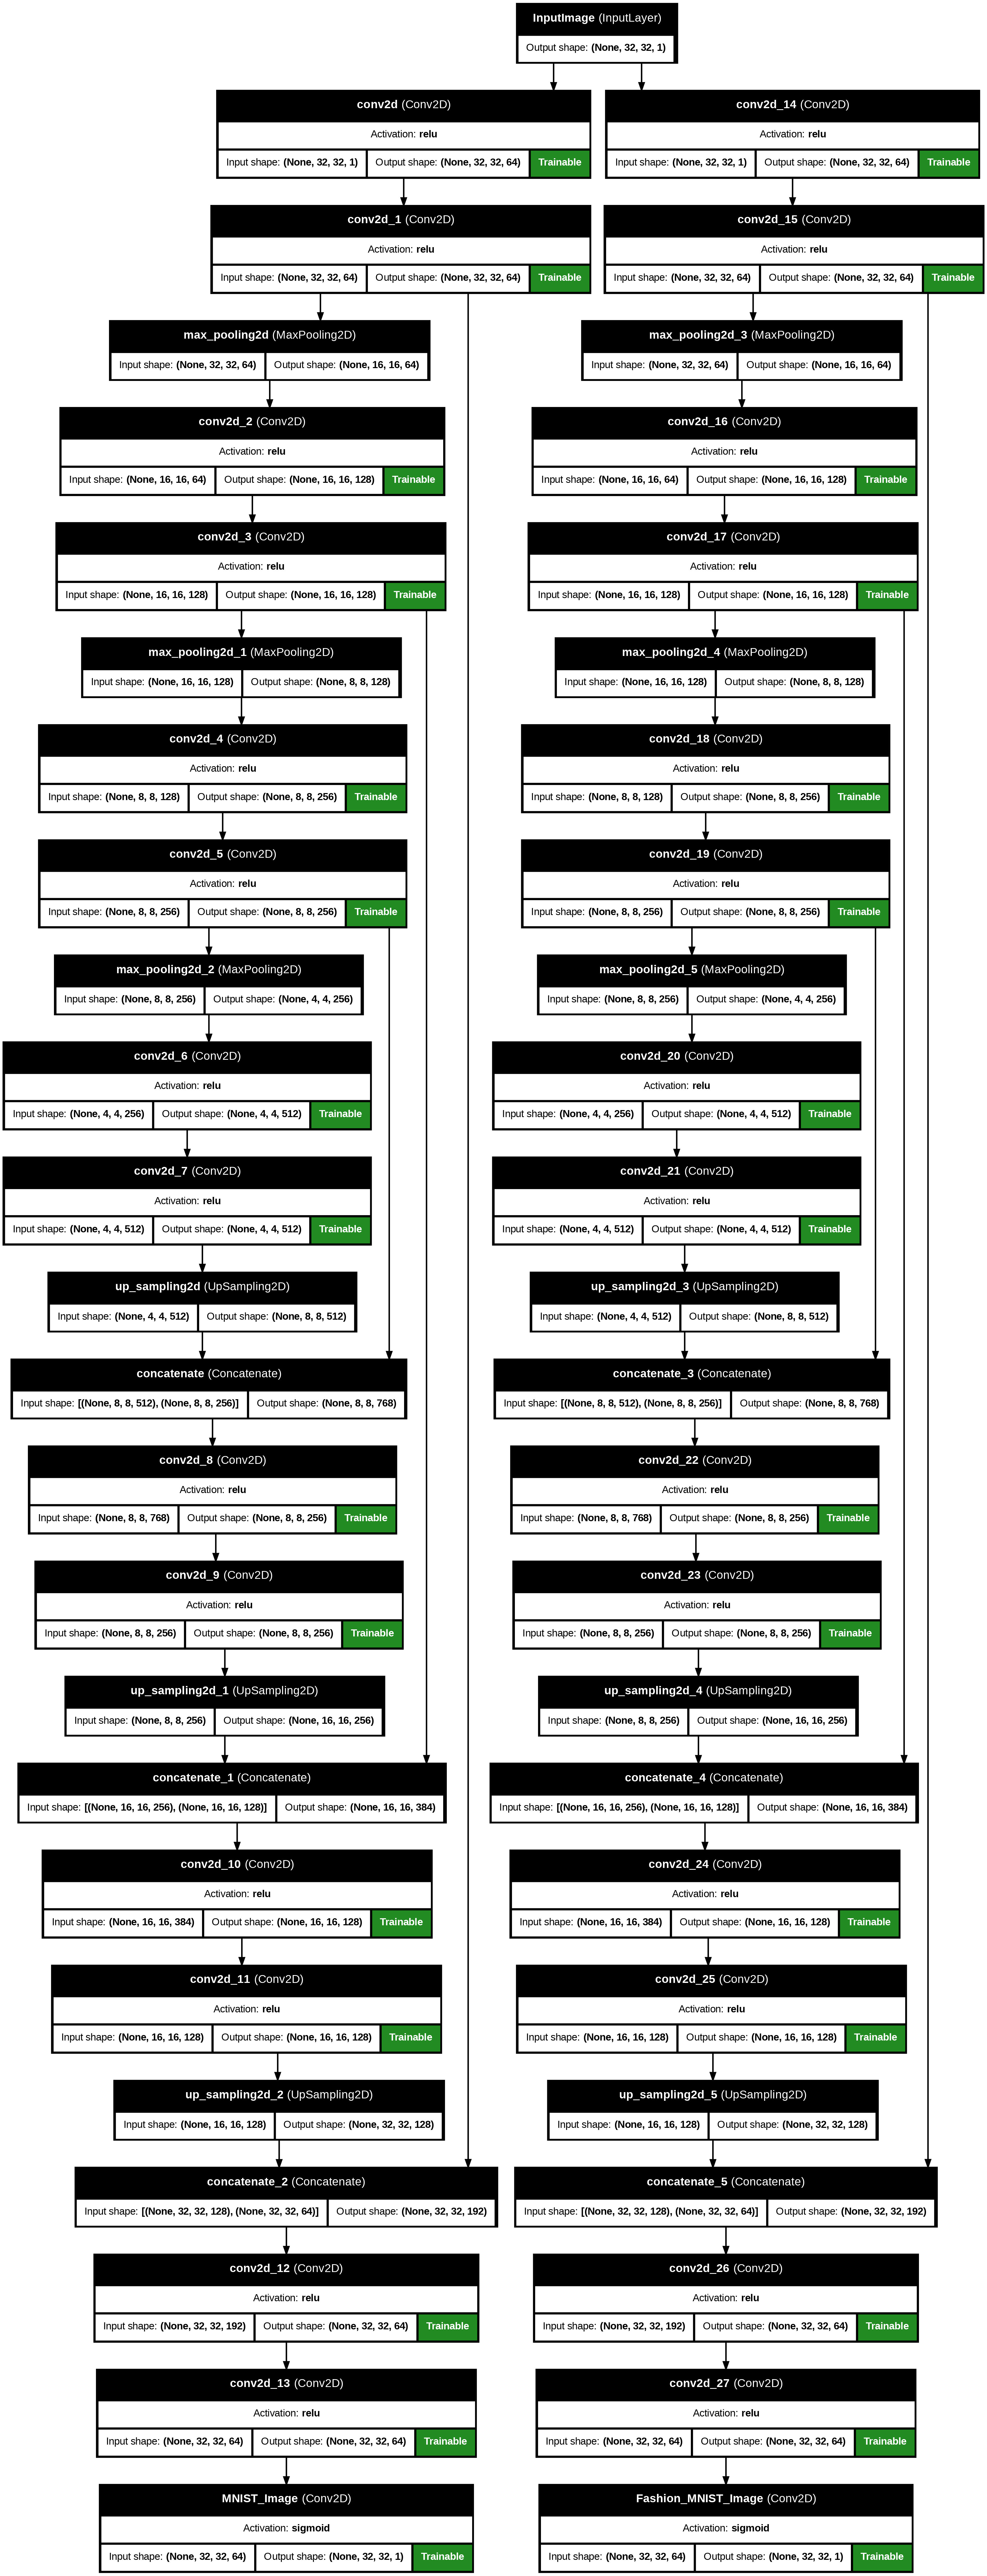

In [23]:
keras.utils.plot_model(model, "model.png", show_shapes = True, show_layer_names = True, show_layer_activations = True, show_trainable = True)

Definisco la funzione di costo che l'addestramento minimizzerà il più possibile.

In [24]:
mse_loss = keras.losses.MeanSquaredError(
    reduction = "sum_over_batch_size",
    name = "mean_squared_error"
)

Compilo la rete.

In [25]:
model.compile(
    loss = mse_loss,
    optimizer = keras.optimizers.AdamW(learning_rate = learning_rate),
)

Definisco una callback EarlyStopping. Essa valuta alla fine di ogni epoca la funzione di costo sul validation set e decide se fermare l'addestramento oppure no. Utile per stabilire automaticamente un buon numero di epoche di addestramento della rete.

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',                 # Verrà monitorato il costo sui dati di validazione.
    min_delta = 0.0001,                   # Minima differenza del costo considerabile come miglioramento.
    patience = early_stopping_patience,   # Numero minimo di epoche da attendere prima di fermare in anticipo l'addestramento.
    restore_best_weights = True,          # Alla fine dell'addestramento, verranno ripristinati i pesi migliori secondo il costo.
    start_from_epoch = 5                  # Epoca dalla quale inizierà il monitoraggio del costo sui dati di validazione.
)

Definisco una callback "BackupAndRestore".  
Alla fine di ogni epoca di addestramento, essa salva lo stato dell'addestramento in file di backup temporanei.  
Se il notebook dovesse bloccarsi a tempo di esecuzione, sarà possibile riavviare l'addestramento ripristinando l'ultimo stato salvato nei file di backup.

In [27]:
backup_and_restore = keras.callbacks.BackupAndRestore(backup_dir = training_backup_path)

Definisco una callback per il controllo del learning rate.

In [28]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',           # Verrà monitorato il costo sui dati di validazione.
    factor = 0.2,                   # Fattore di riduzione del learning rate.
    patience = reduce_lr_patience,  # Numero minimo di epoche da attendere prima di ridurre il learning rate.
    min_lr = minimum_lr             # Minimo valore che il learning rate potrà assumere durante l'addestramento.
)

Se è disponibile un file di pesi del modello, carico i pesi e salto
l'addestramento.  
Altrimenti, addestro il modello e salvo i pesi risultanti.

In [30]:
loaded = True
try:
  print('Ricerca di un file dei pesi in corso...')
  model.load_weights(net_parameters_path)
  print('Pesi caricati')
except:
  loaded = False
  print('Nessun file dei pesi trovato')
  history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val), callbacks = [early_stopping, backup_and_restore, reduce_lr])
  print('Salvataggio dei pesi in corso...')
  model.save_weights(net_parameters_path)
  print('Pesi salvati')

Ricerca di un file dei pesi in corso...
Nessun file dei pesi trovato
Epoch 1/250
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 237s 55ms/step - Fashion_MNIST_Image_loss: 0.0150 - MNIST_Image_loss: 0.0881 - loss: 0.1030 - val_Fashion_MNIST_Image_loss: 0.0017 - val_MNIST_Image_loss: 0.0858 - val_loss: 0.0875 - learning_rate: 1.0000e-04
Epoch 2/250
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 198s 51ms/step - Fashion_MNIST_Image_loss: 0.0016 - MNIST_Image_loss: 0.0858 - loss: 0.0873 - val_Fashion_MNIST_Image_loss: 0.0012 - val_MNIST_Image_loss: 0.0858 - val_loss: 0.0870 - learning_rate: 1.0000e-04
Epoch 3/250
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 198s 51ms/step - Fashion_MNIST_Image_loss: 0.0011 - MNIST_Image_loss: 0.0858 - loss: 0.0869 - val_Fashion_MNIST_Image_loss: 9.6074e-04 - val_MNIST_Image_loss: 0.0858 - val_loss: 0.0867 - learning_rate: 1.0000e-04
Epoch 4/250
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 198s 51ms/step - Fashion_MNIST_Image_loss: 8.9038e-04 - MNIST_Image_loss: 0.0858 - loss: 0.0866 - val_Fashion_MNIST_Image_loss: 

Ora definisco una funzione per la creazione di grafici della storia dell'addestramento.  
Se non sono stati caricati dei pesi e, quindi, è stato eseguito l'addestramento, allora vengono mostrati quattro grafici.

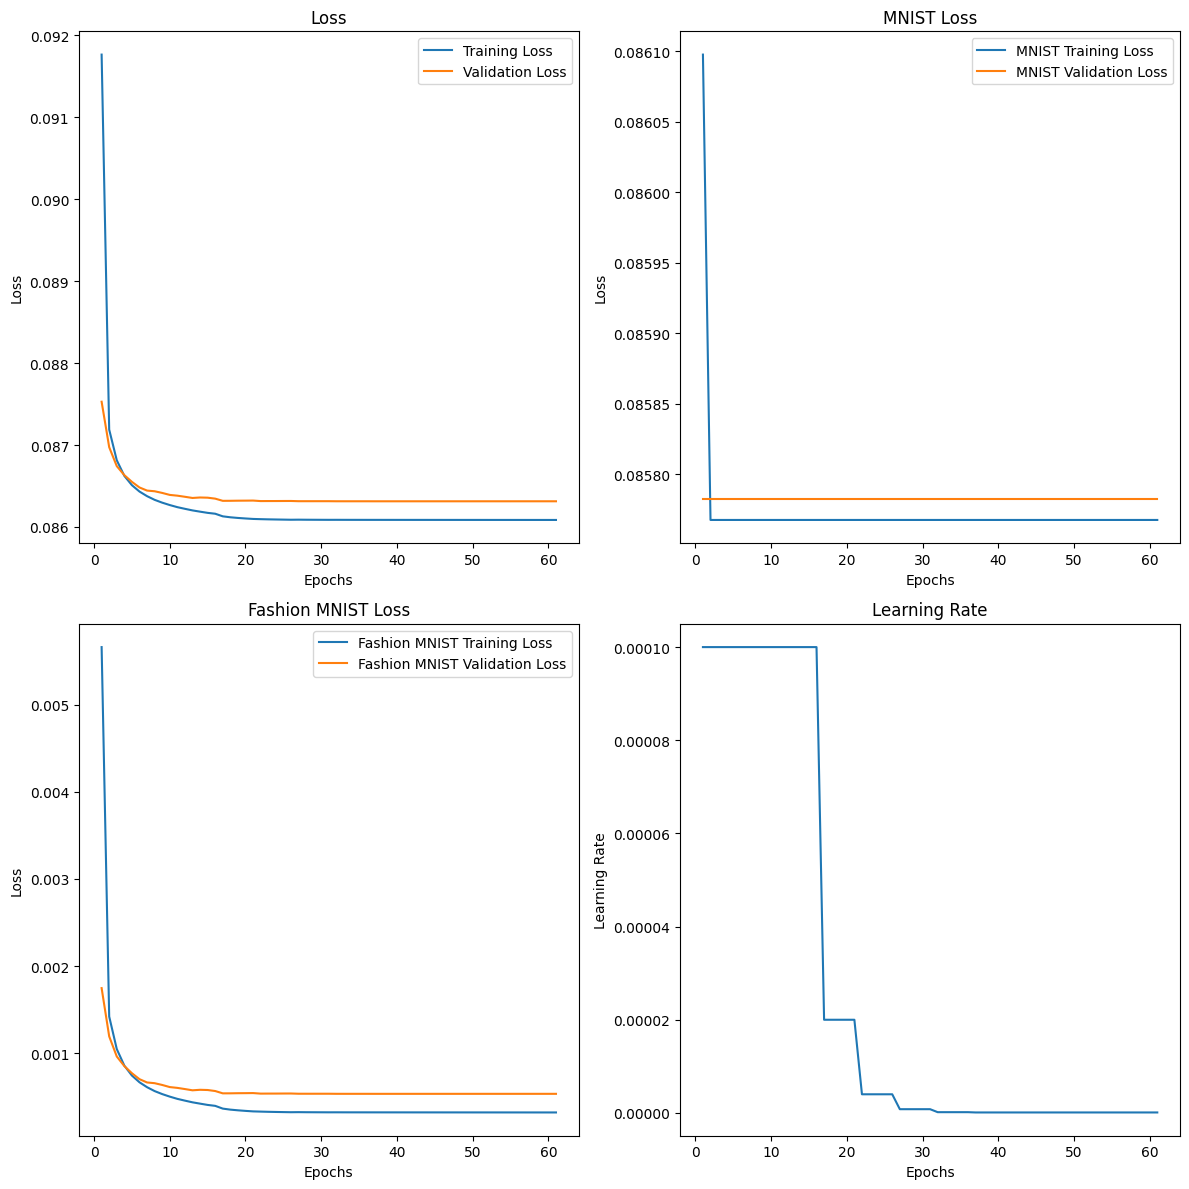

In [31]:
def plot_training_history(history):

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    mnist_training_loss = history.history['MNIST_Image_loss']
    mnist_validation_loss = history.history['val_MNIST_Image_loss']
    fashion_mnist_training_loss = history.history['Fashion_MNIST_Image_loss']
    fashion_mnist_validation_loss = history.history['val_Fashion_MNIST_Image_loss']
    learning_rate = history.history['learning_rate']

    # Crea un grafico
    epochs = range(1, len(training_loss) + 1)
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, mnist_training_loss, label='MNIST Training Loss')
    plt.plot(epochs, mnist_validation_loss, label='MNIST Validation Loss')
    plt.title('MNIST Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, fashion_mnist_training_loss, label='Fashion MNIST Training Loss')
    plt.plot(epochs, fashion_mnist_validation_loss, label='Fashion MNIST Validation Loss')
    plt.title('Fashion MNIST Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, learning_rate)
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')

    plt.tight_layout()
    plt.show()

if not loaded:
  plot_training_history(history)

Definisco due funzioni per la valutazione finale del modello.

In [32]:
def eval_model(model):
  x, (y1, y2) = next(testgen)
  if isinstance(model, keras.Model):
    pred1, pred2 = model.predict(x)
  else:
    pred1, pred2 = model(x)

  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2)) / 2

def multiple_eval_model(model, repeat_eval = 10):
  eval_results = []
  for i in range(repeat_eval):
    eval_results.append(eval_model(model))
  print("mse mean = ", np.mean(eval_results))
  print("mse standard deviation = ", np.std(eval_results))

Valuto la rete e il modello casuale e confronto le loro prestazioni.  
Più questi valori sono vicini a zero, più la rete è accurata.

In [33]:
print('Valutazione modello banale')
multiple_eval_model(ide_model)

print('Valutazione rete neurale')
multiple_eval_model(model)

Valutazione modello banale
mse mean =  0.036257001774858216
mse standard deviation =  0.00021109807797524232
Valutazione rete neurale
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mse mean =  0.043991187618609554
mse standard deviation =  0.00017401512748984097


Mostro 30 esempi di previsioni del modello banale e della rete neurale.

Campione di esempio numero  1


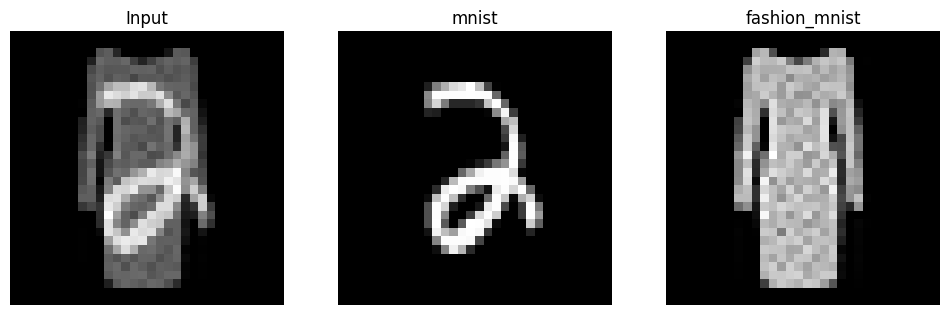

Previsione del modello banale


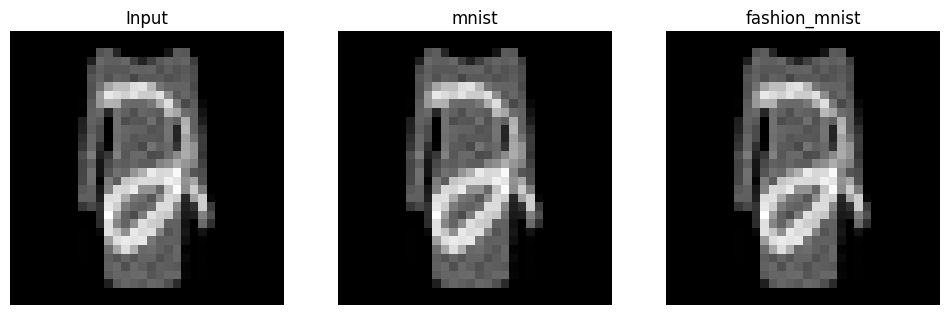

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


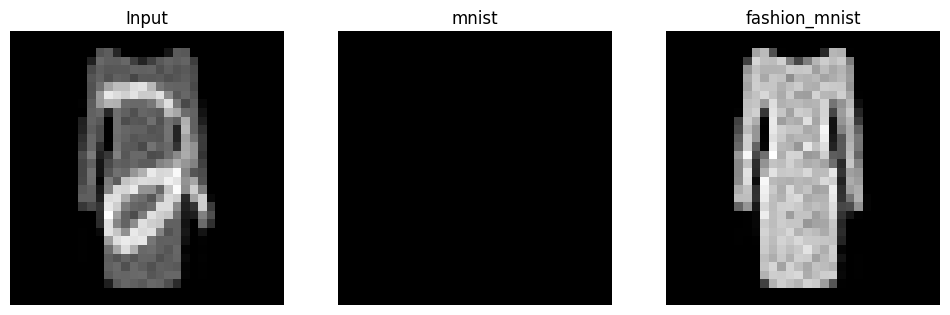



Campione di esempio numero  2


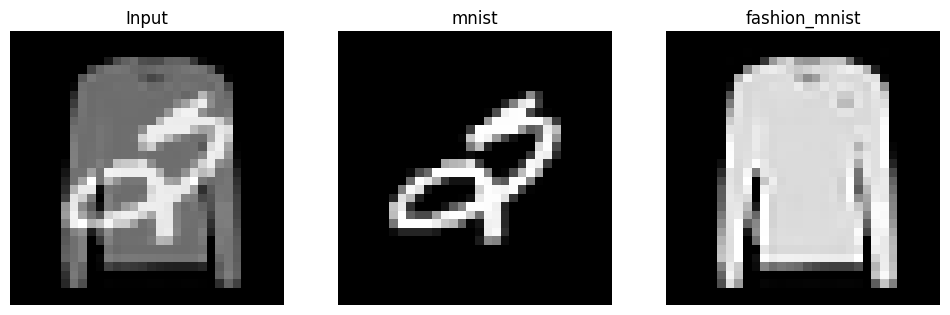

Previsione del modello banale


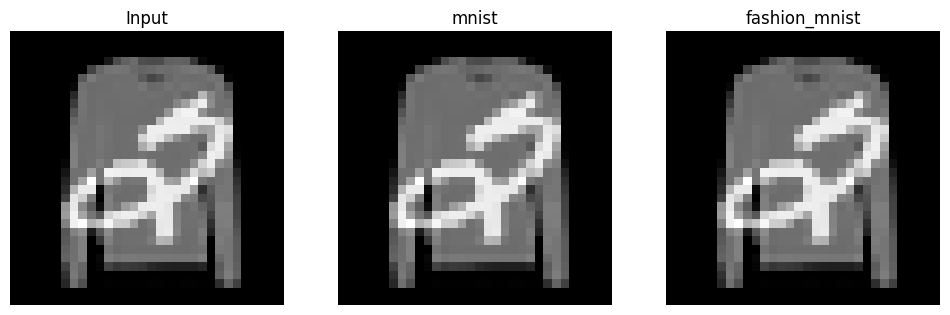

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


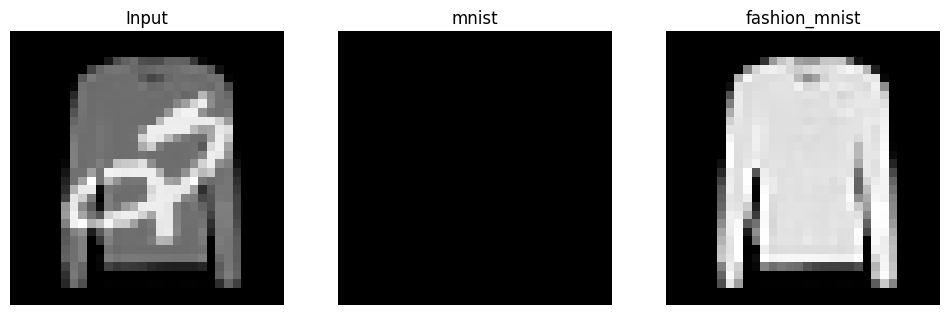



Campione di esempio numero  3


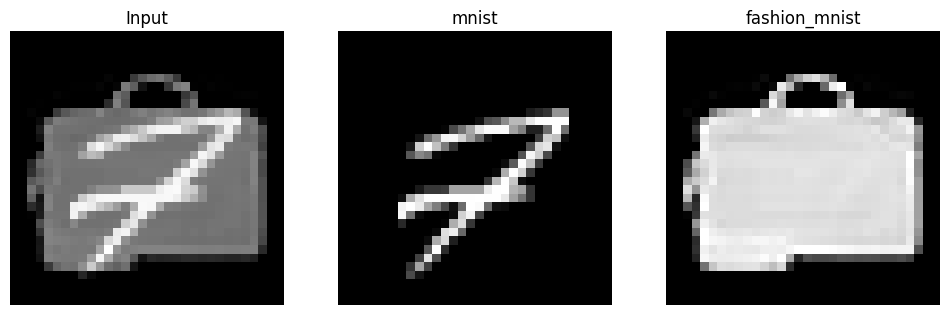

Previsione del modello banale


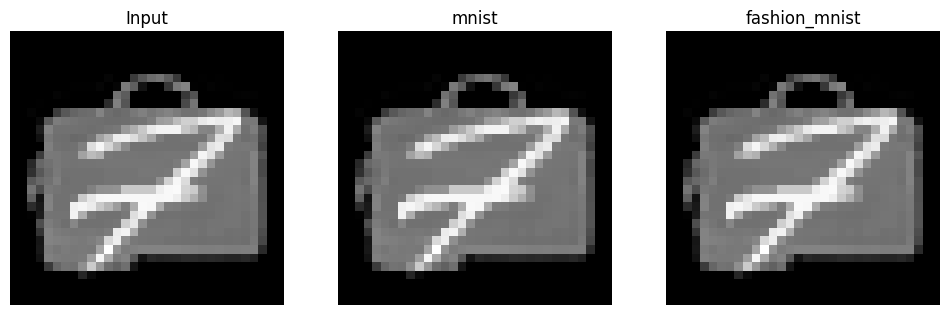

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


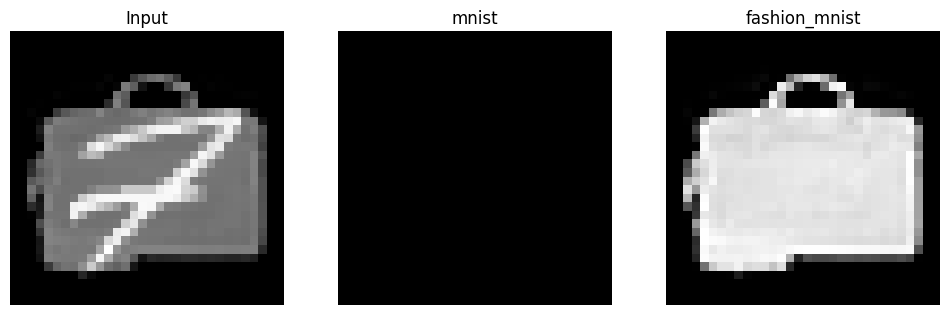



Campione di esempio numero  4


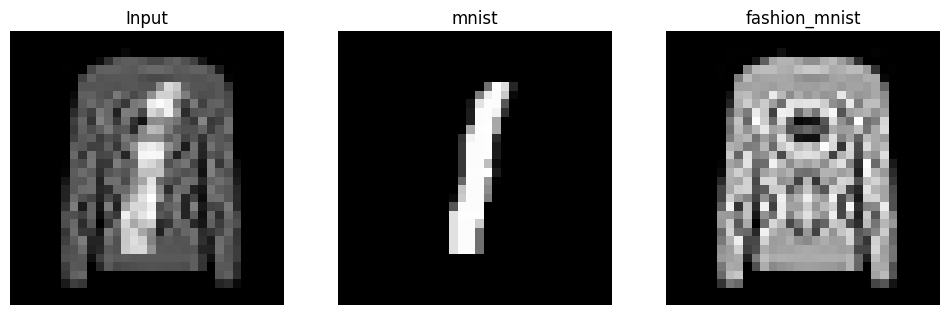

Previsione del modello banale


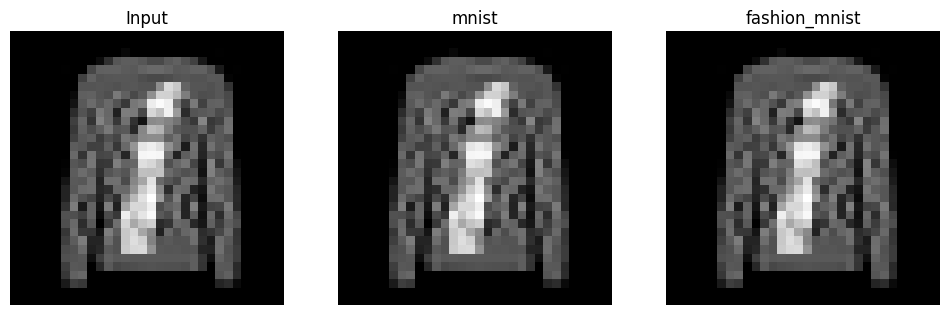

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


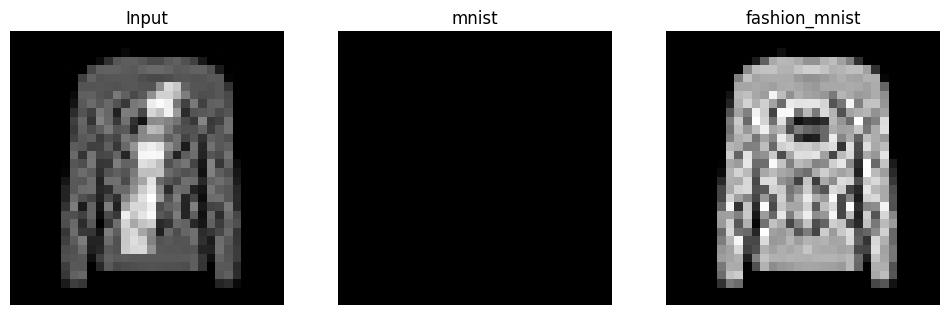



Campione di esempio numero  5


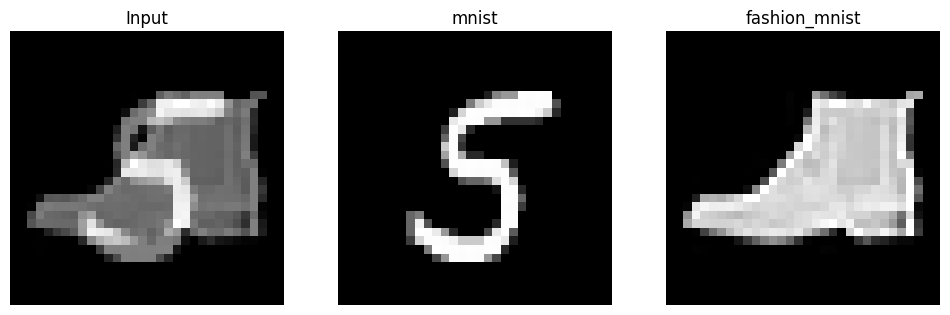

Previsione del modello banale


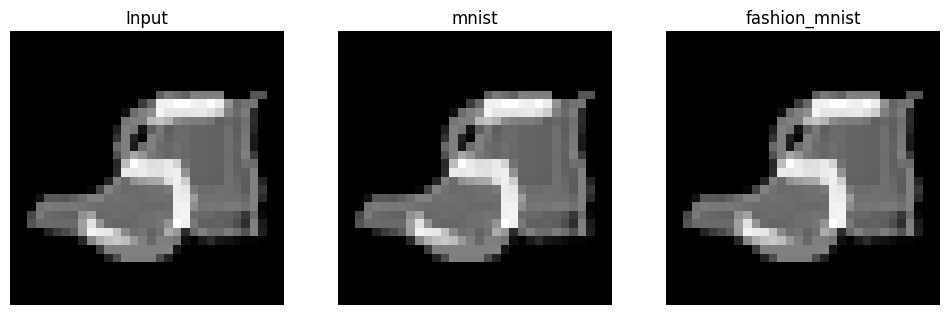

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


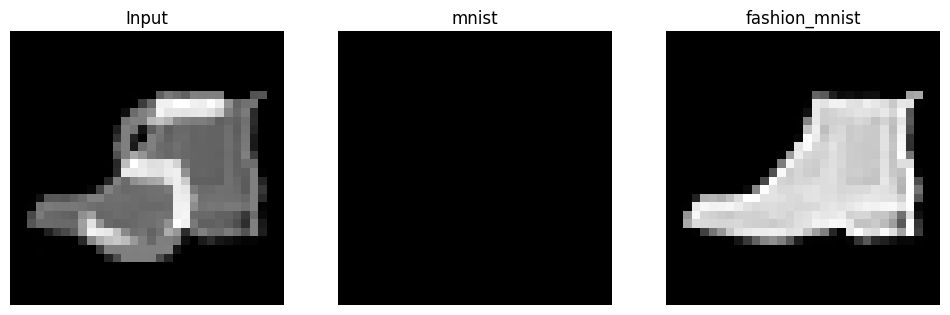



Campione di esempio numero  6


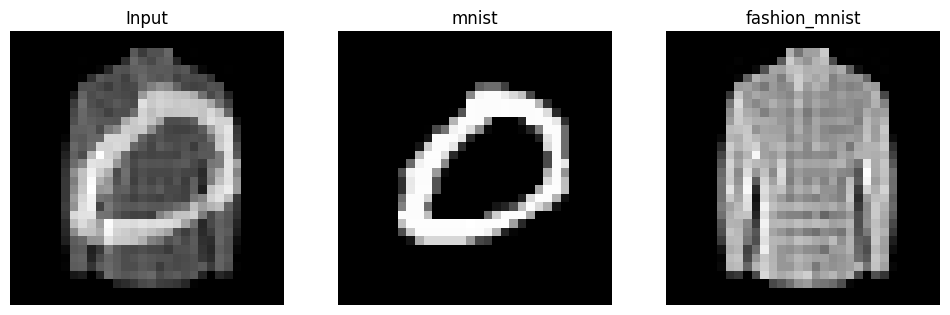

Previsione del modello banale


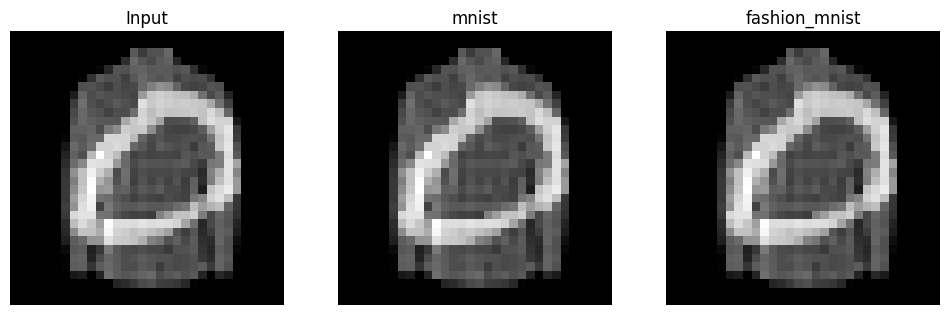

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


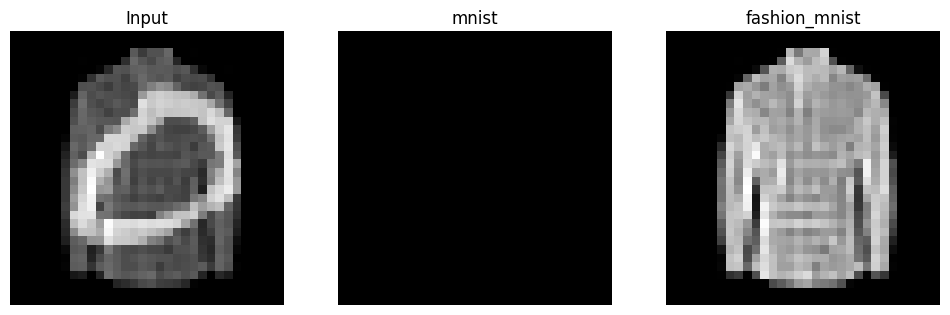



Campione di esempio numero  7


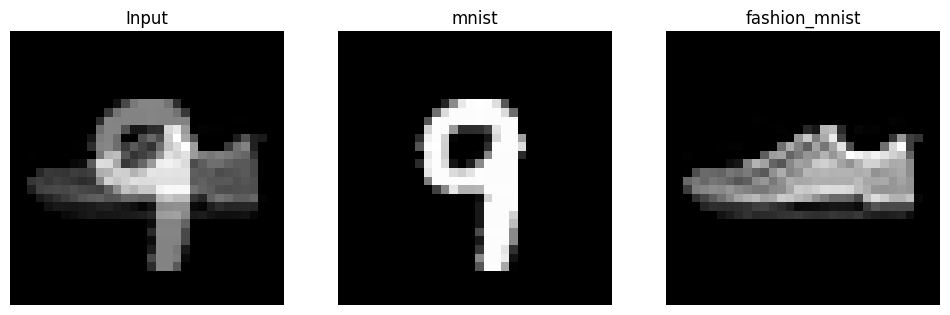

Previsione del modello banale


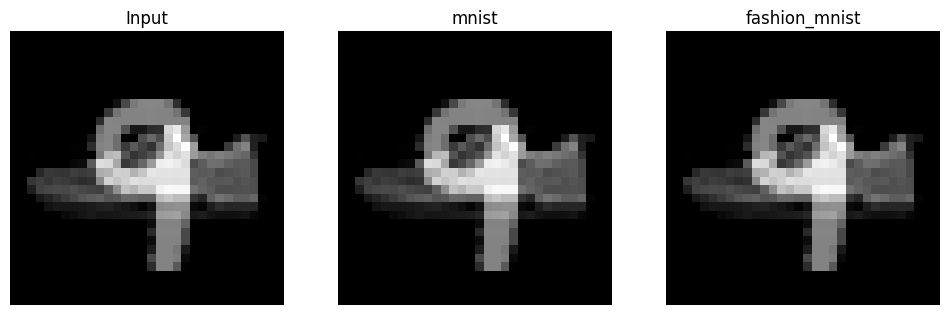

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


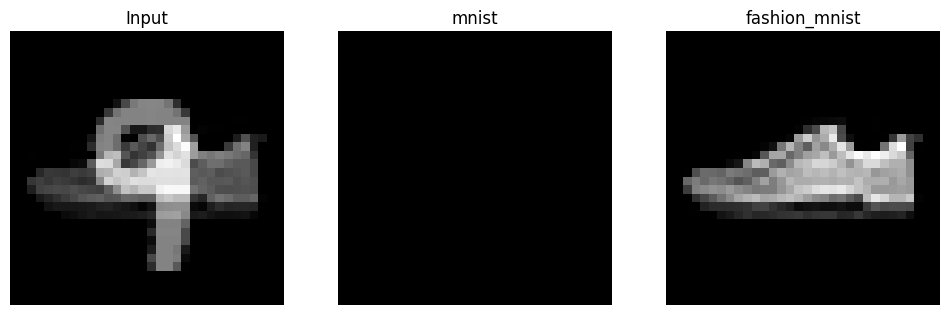



Campione di esempio numero  8


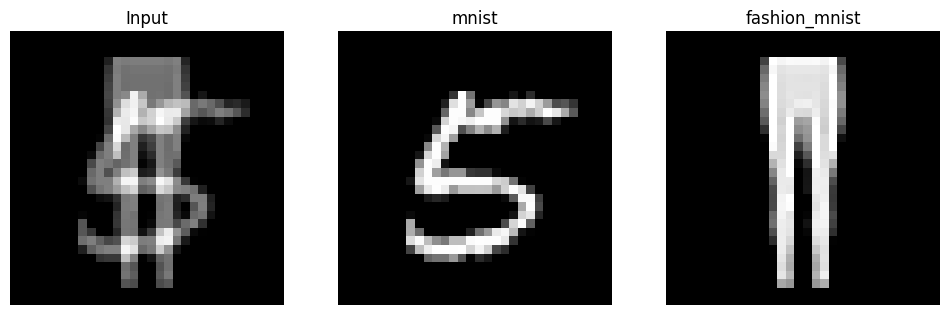

Previsione del modello banale


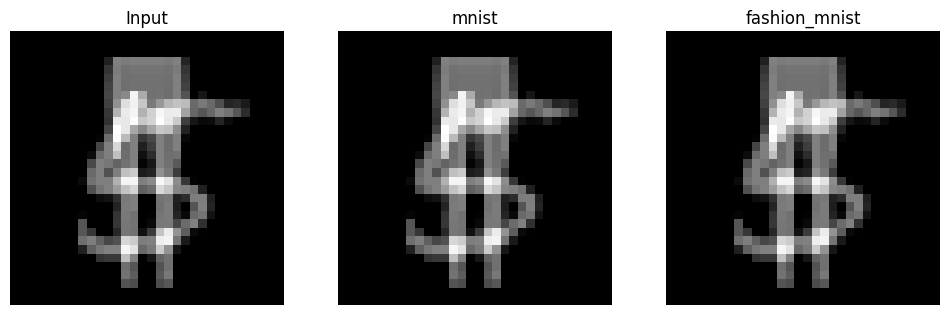

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


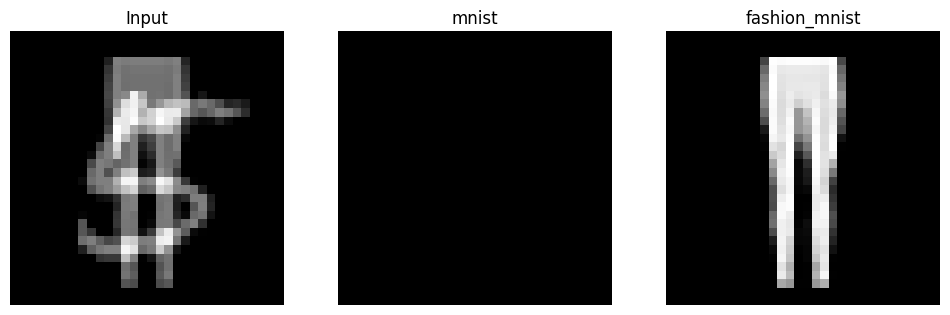



Campione di esempio numero  9


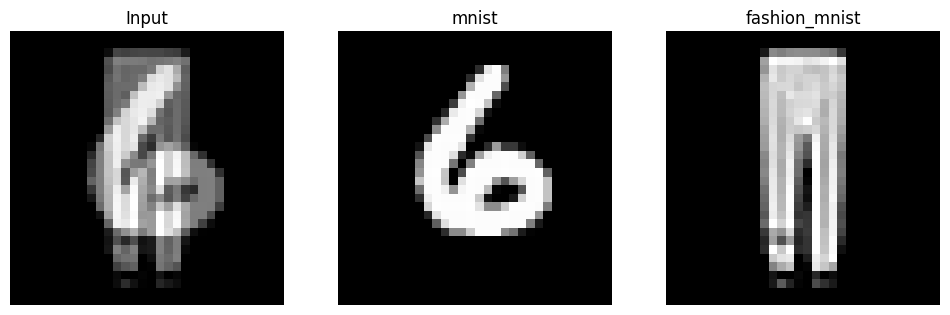

Previsione del modello banale


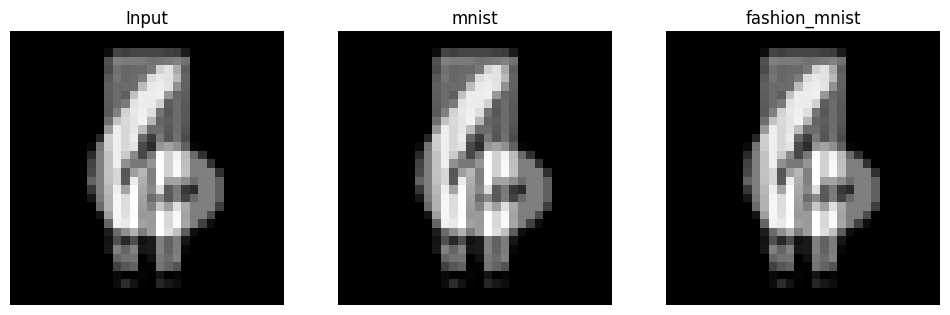

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


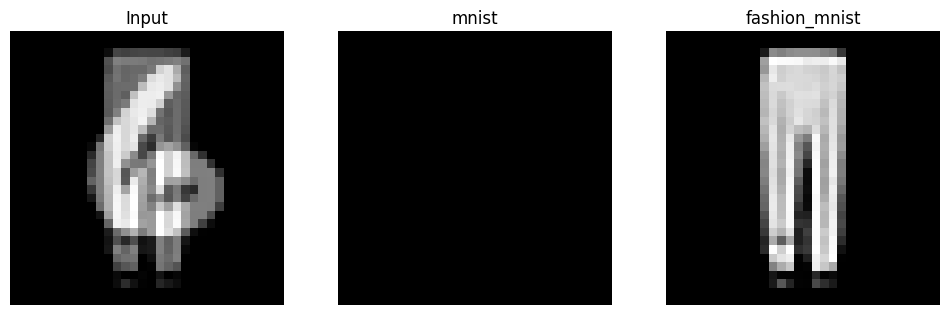



Campione di esempio numero  10


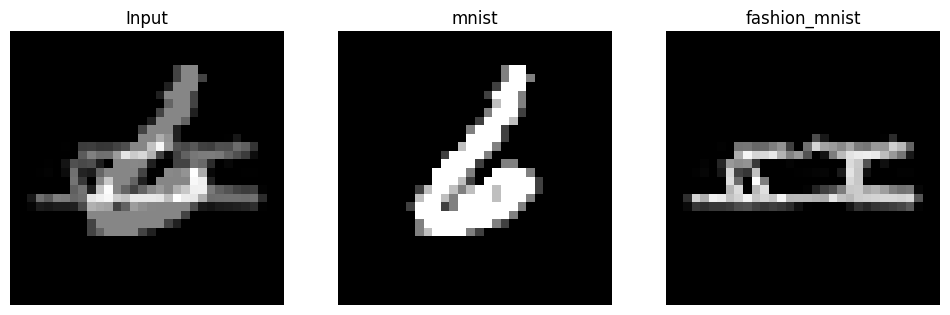

Previsione del modello banale


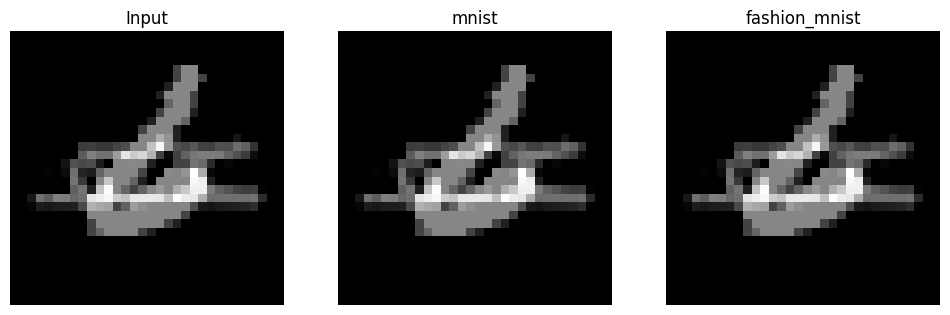

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


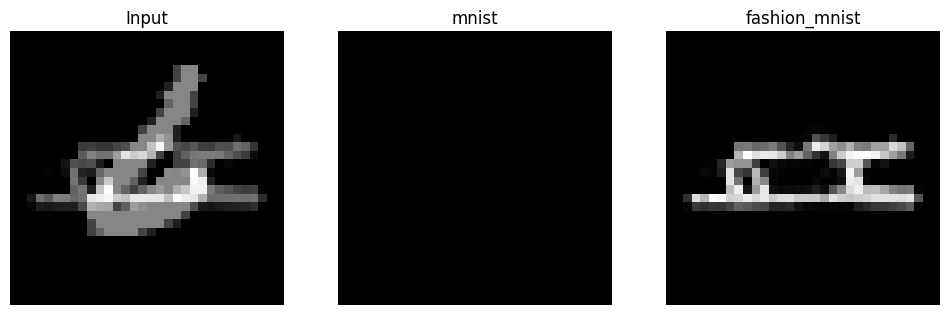



Campione di esempio numero  11


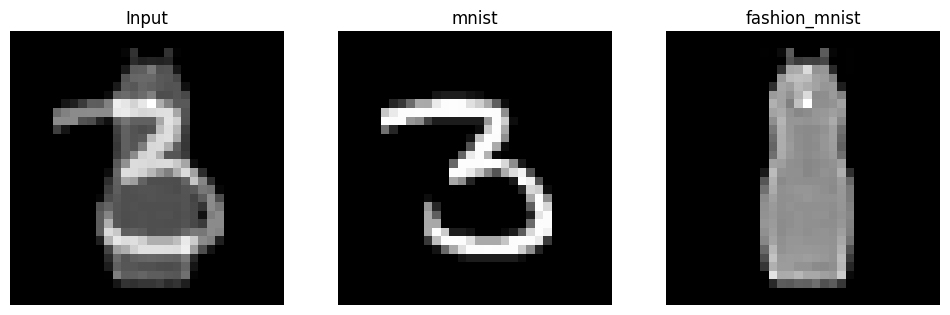

Previsione del modello banale


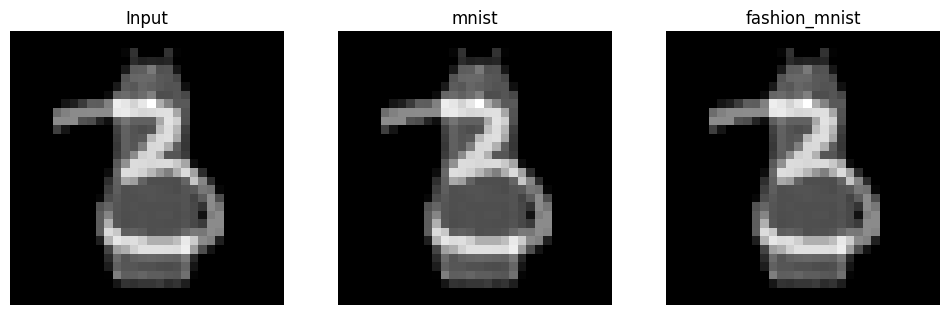

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


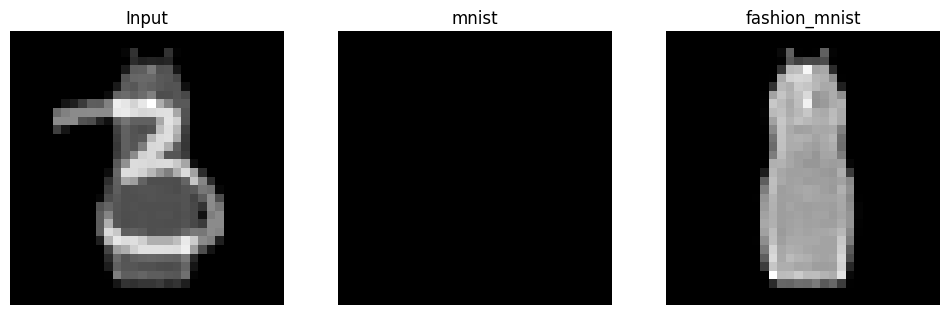



Campione di esempio numero  12


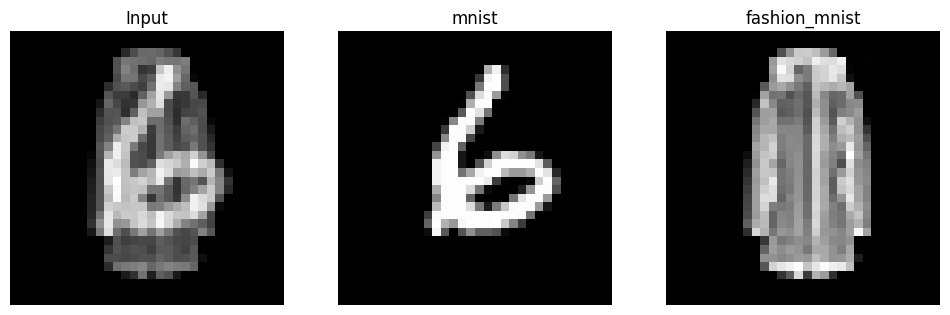

Previsione del modello banale


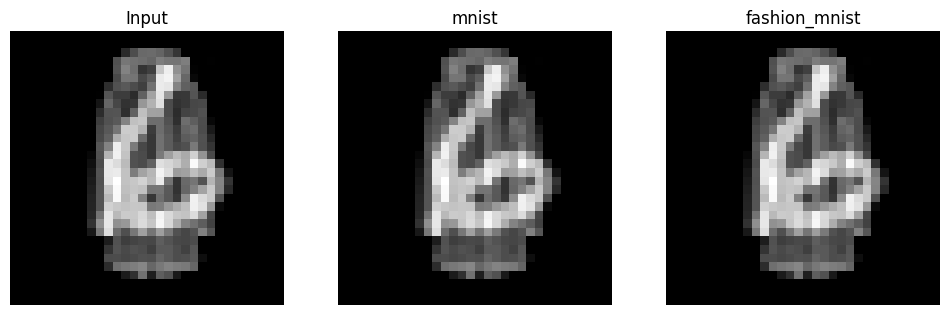

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


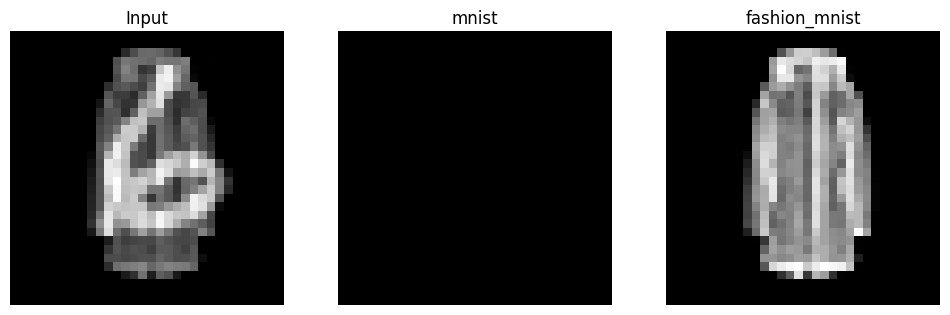



Campione di esempio numero  13


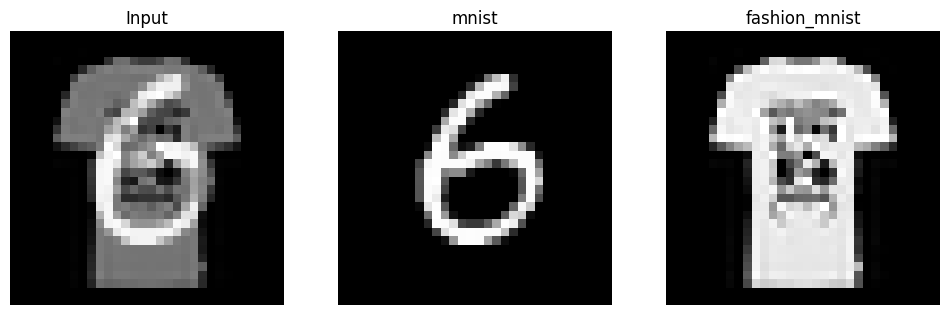

Previsione del modello banale


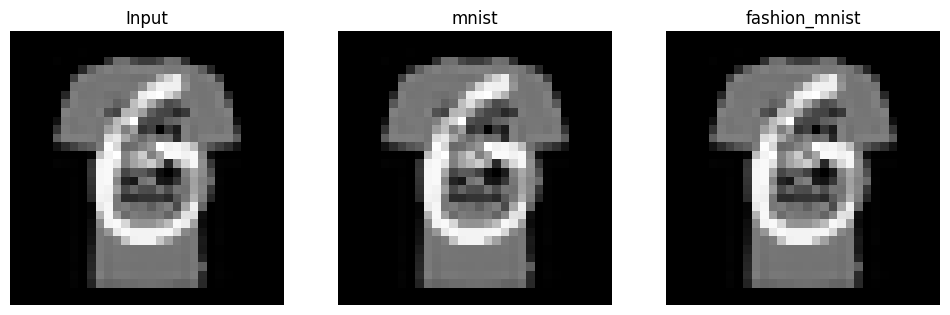

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


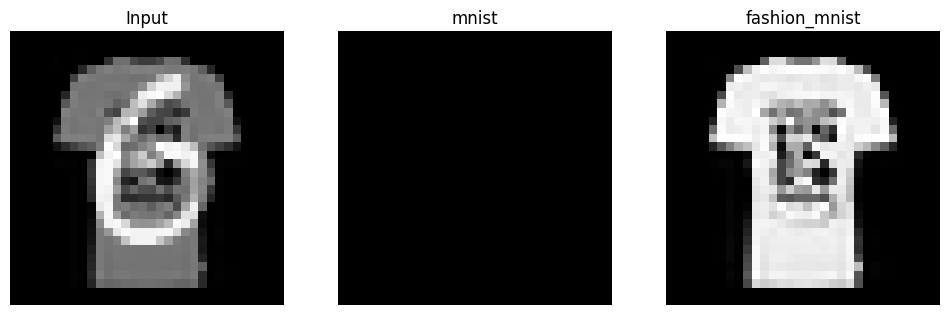



Campione di esempio numero  14


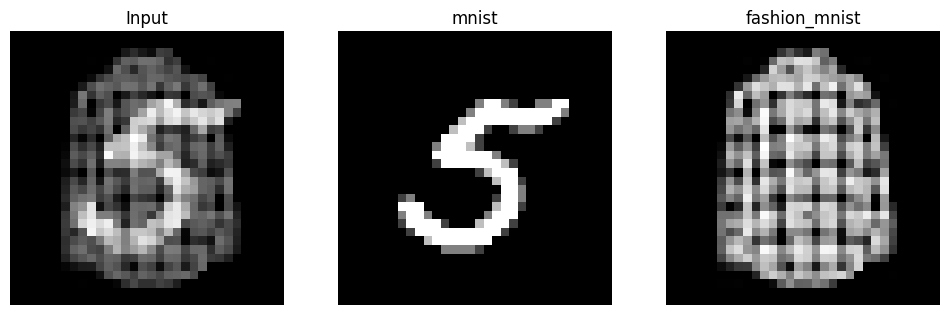

Previsione del modello banale


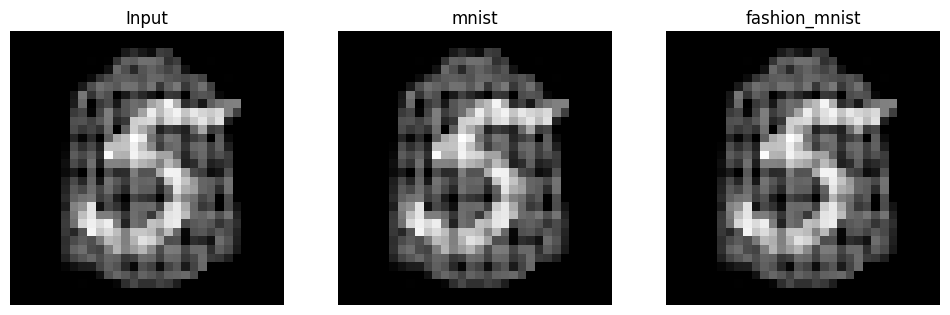

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


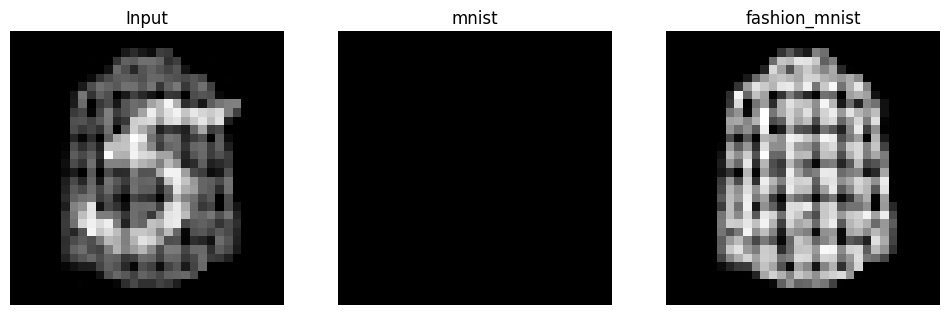



Campione di esempio numero  15


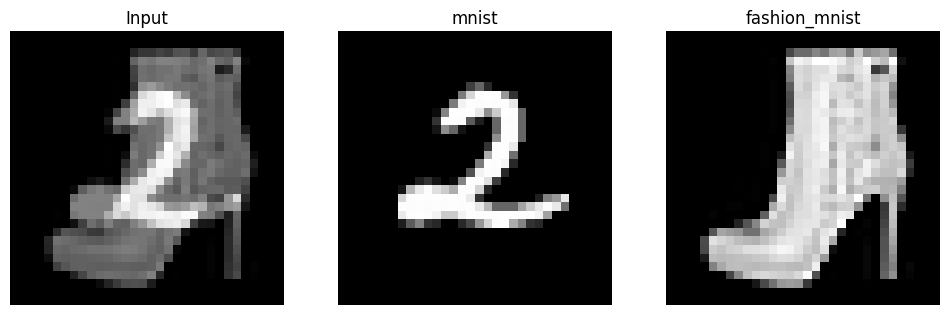

Previsione del modello banale


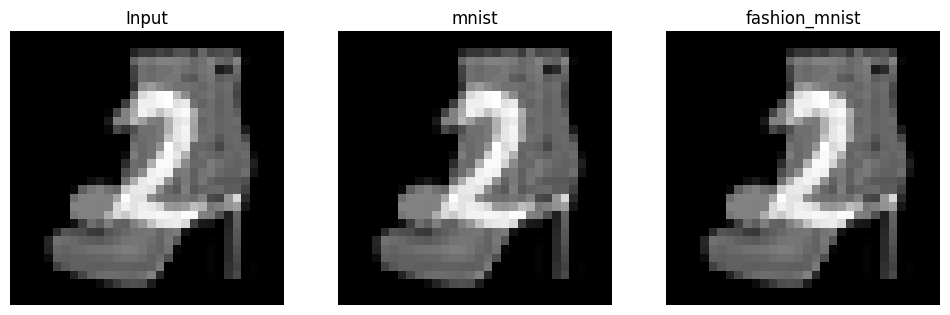

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


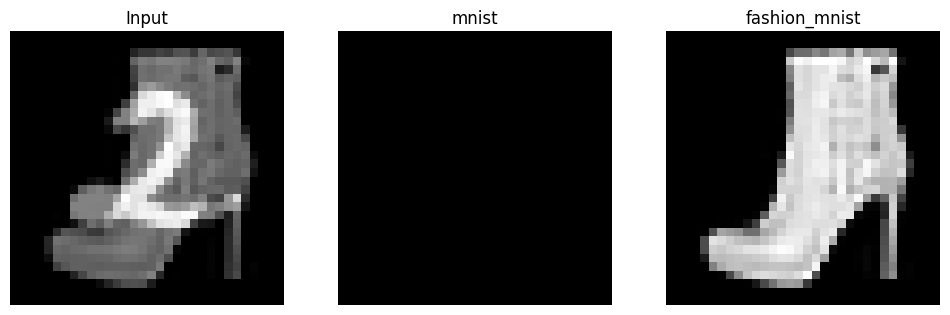



Campione di esempio numero  16


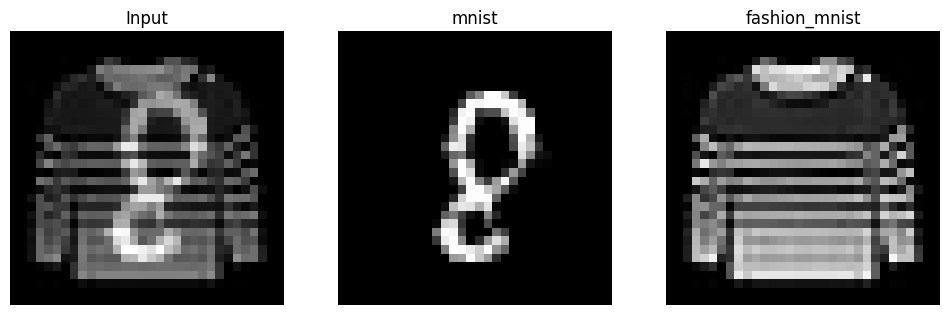

Previsione del modello banale


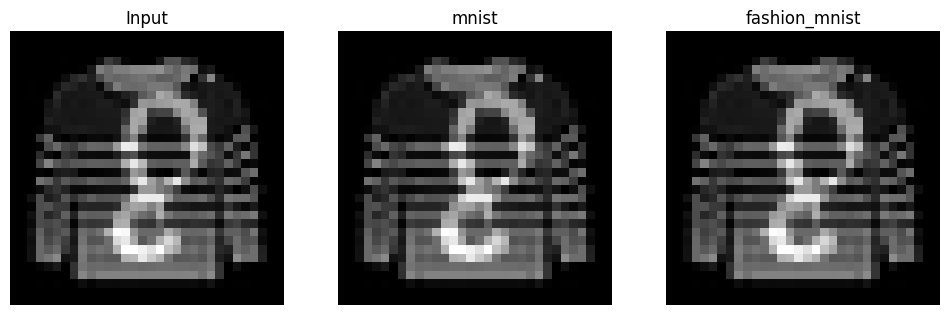

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


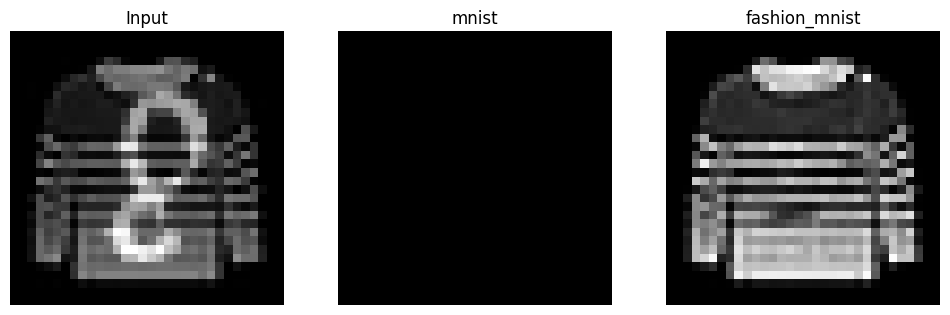



Campione di esempio numero  17


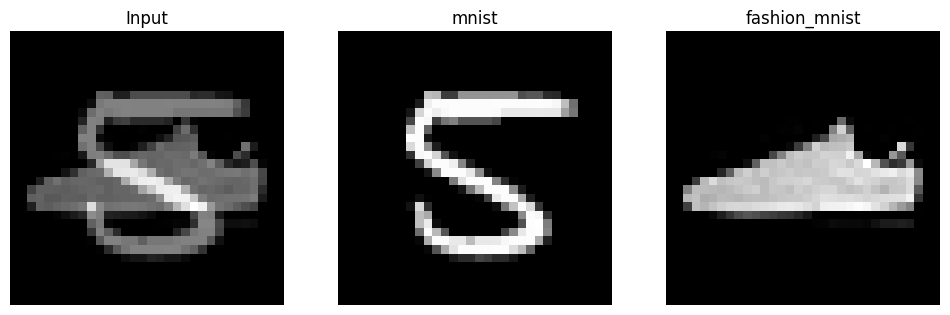

Previsione del modello banale


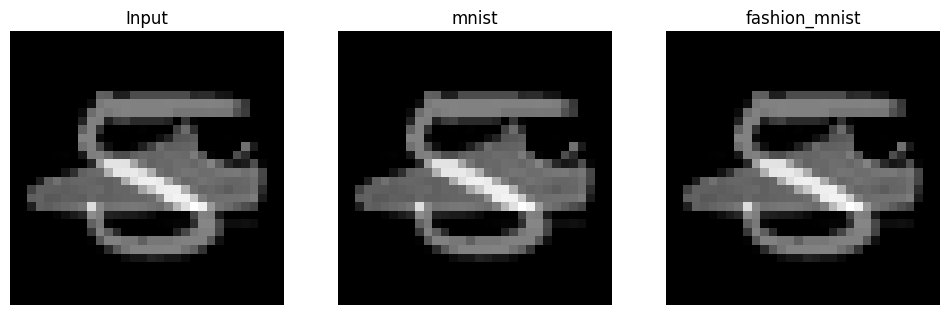

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


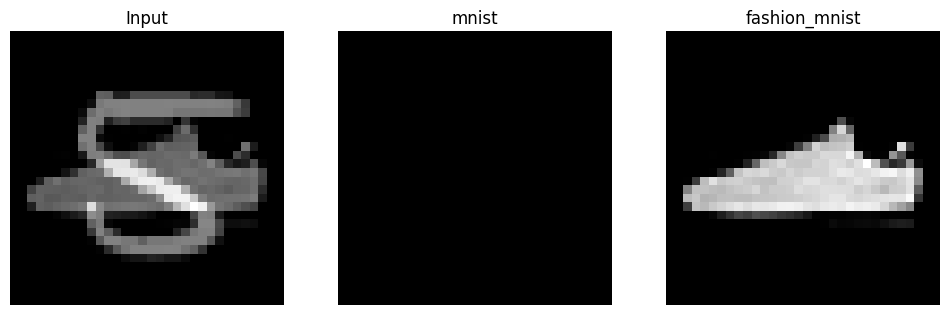



Campione di esempio numero  18


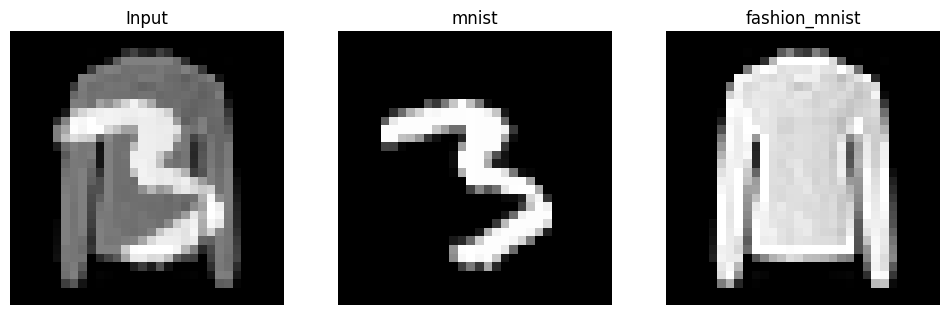

Previsione del modello banale


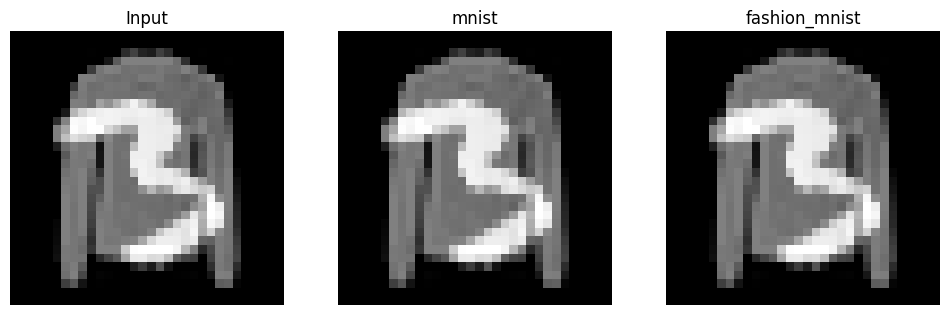

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


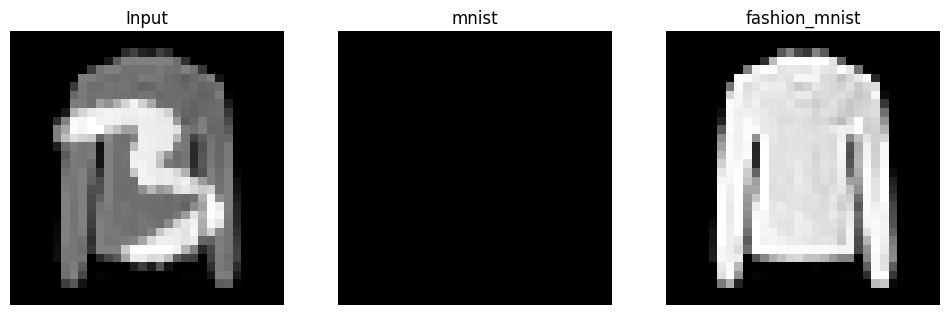



Campione di esempio numero  19


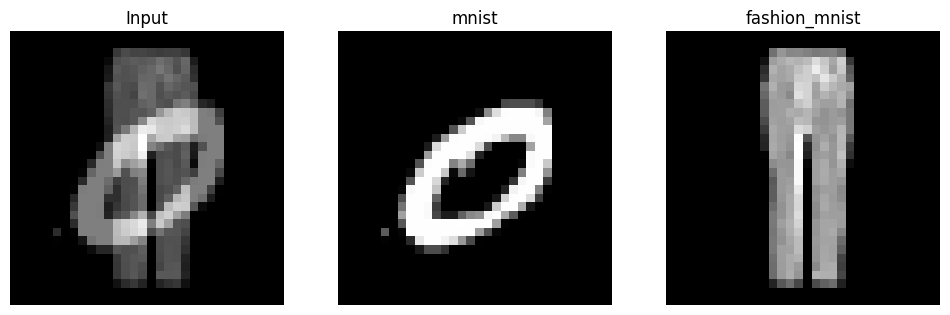

Previsione del modello banale


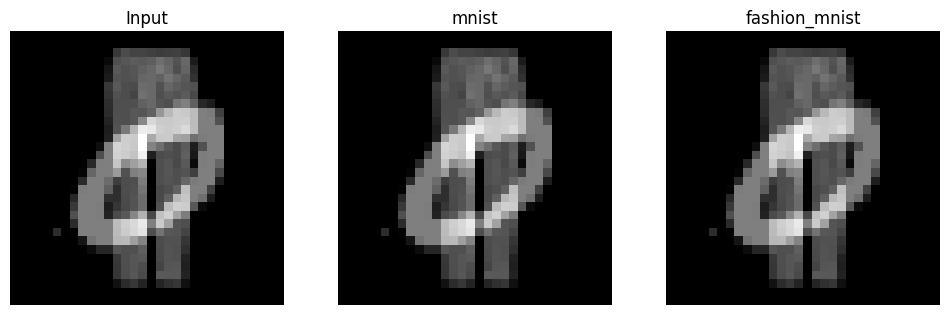

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


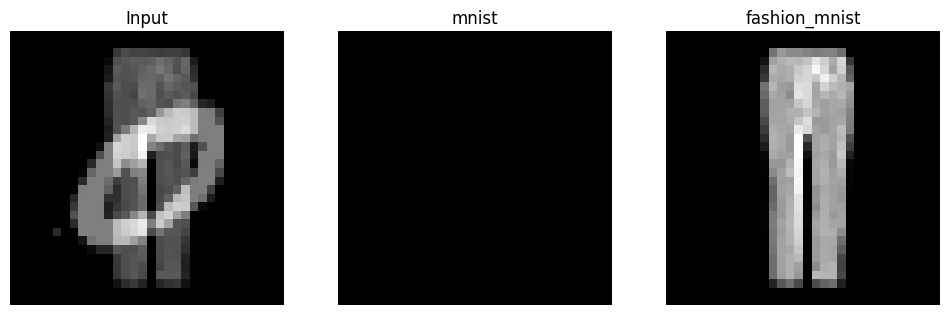



Campione di esempio numero  20


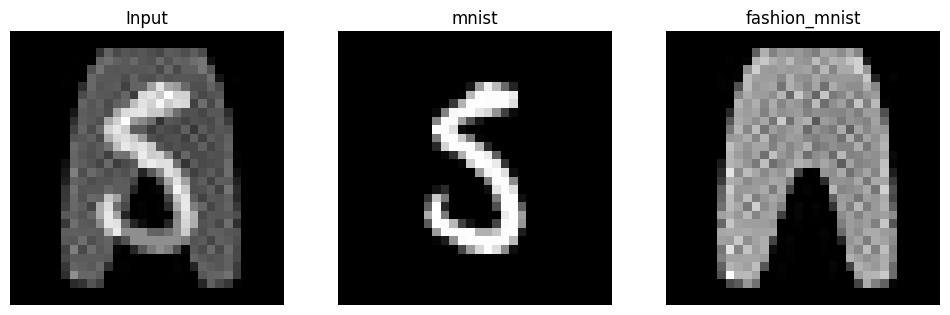

Previsione del modello banale


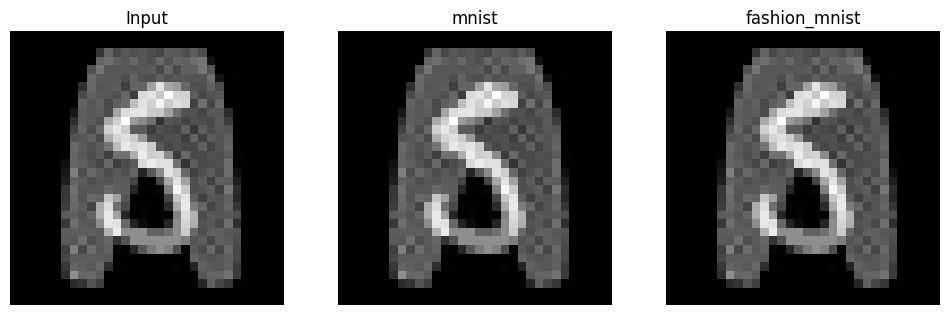

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


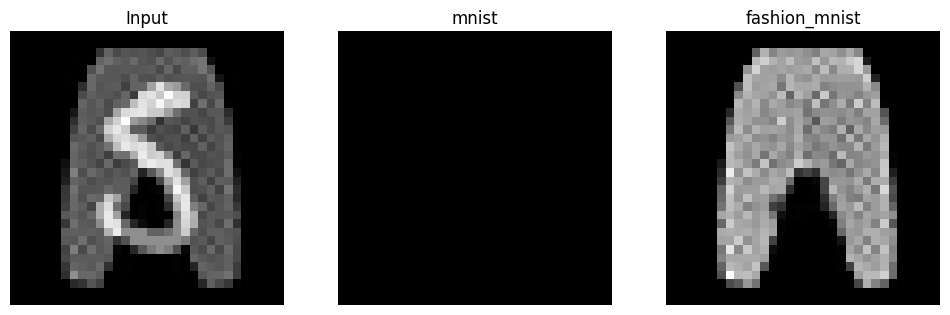



Campione di esempio numero  21


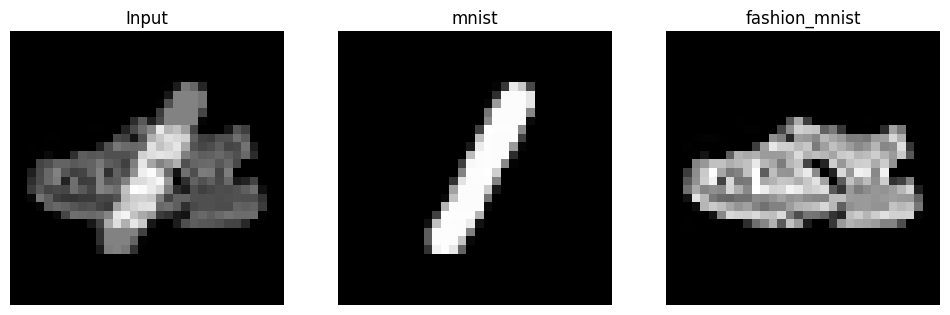

Previsione del modello banale


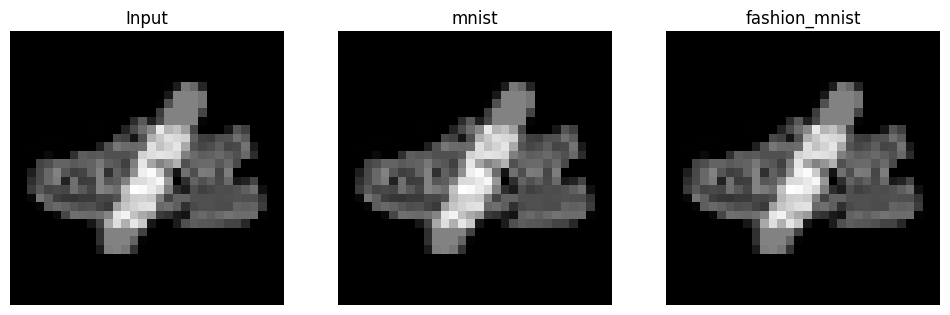

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


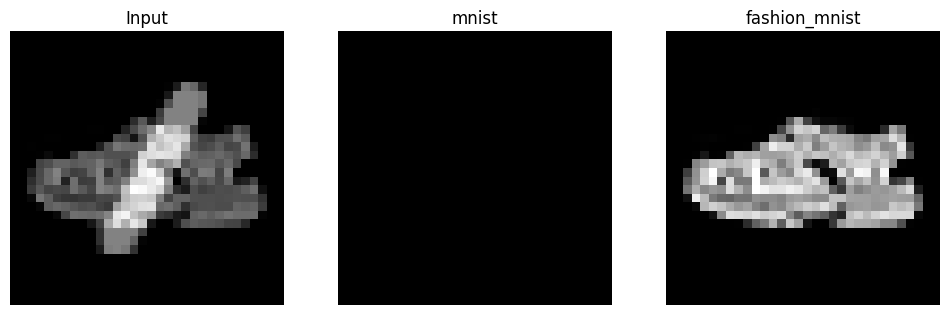



Campione di esempio numero  22


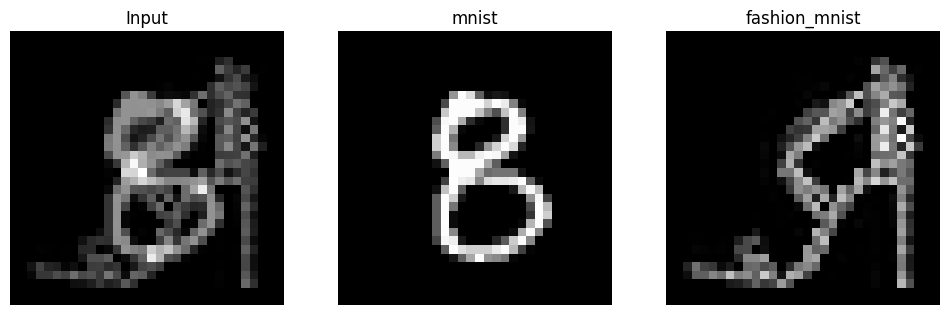

Previsione del modello banale


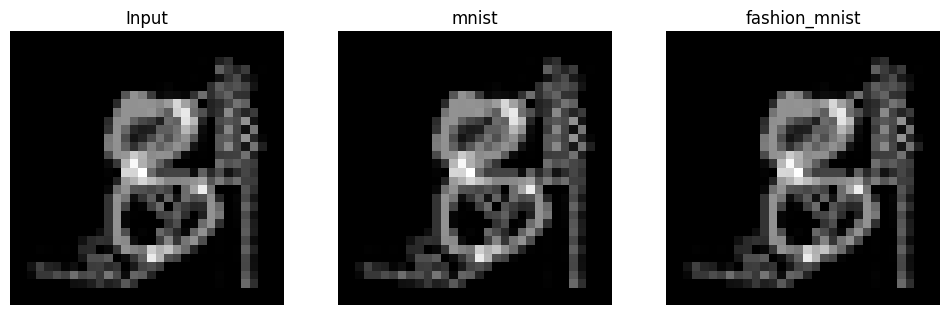

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


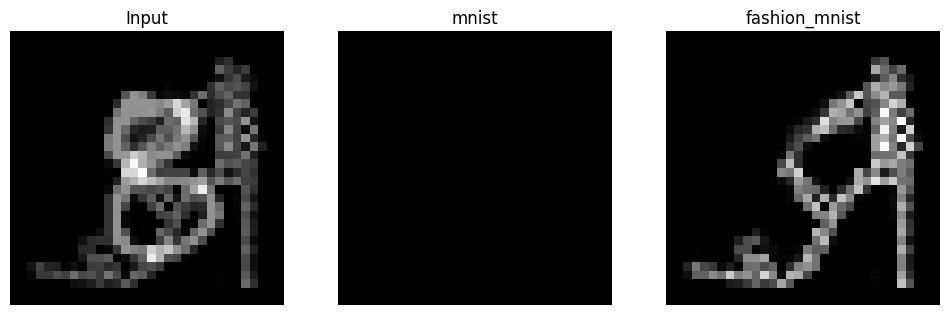



Campione di esempio numero  23


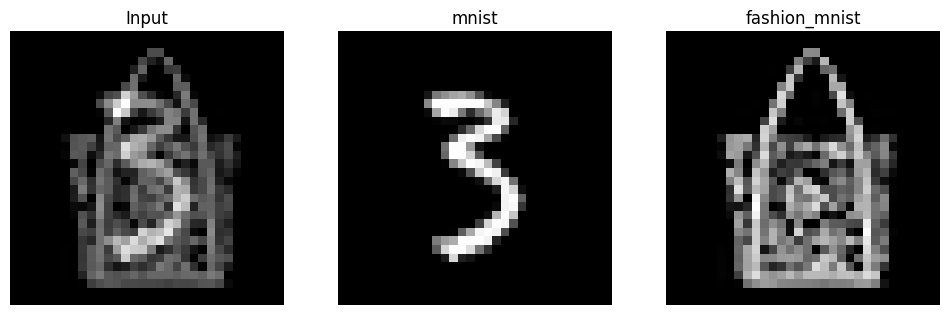

Previsione del modello banale


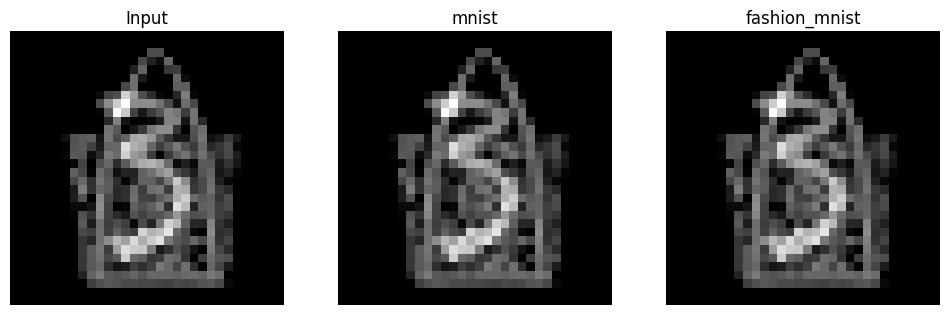

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


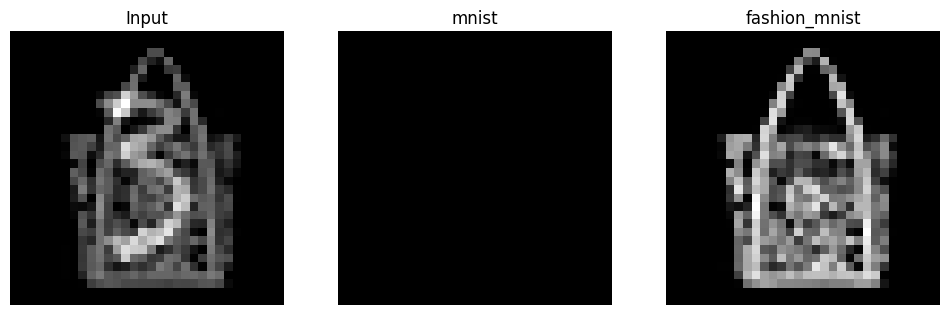



Campione di esempio numero  24


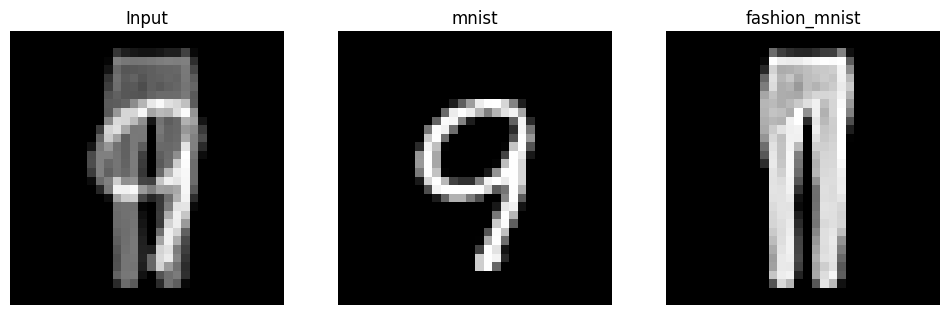

Previsione del modello banale


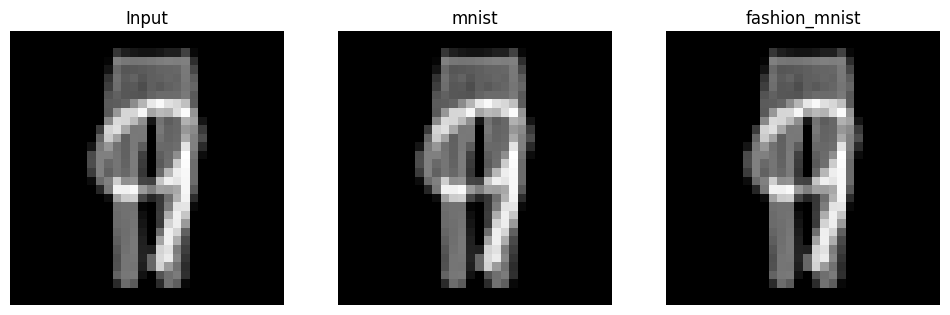

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


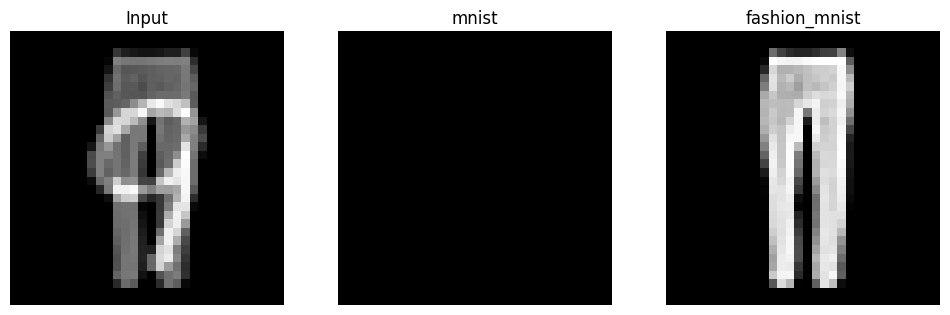



Campione di esempio numero  25


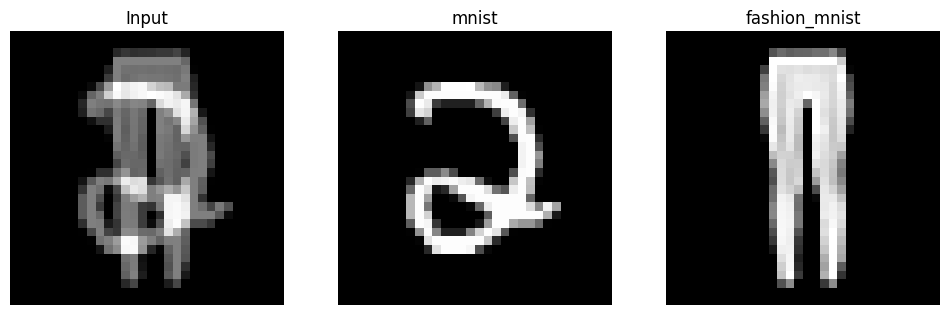

Previsione del modello banale


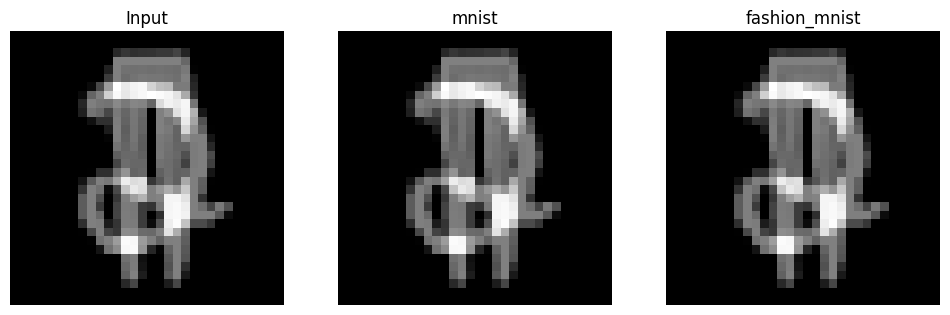

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


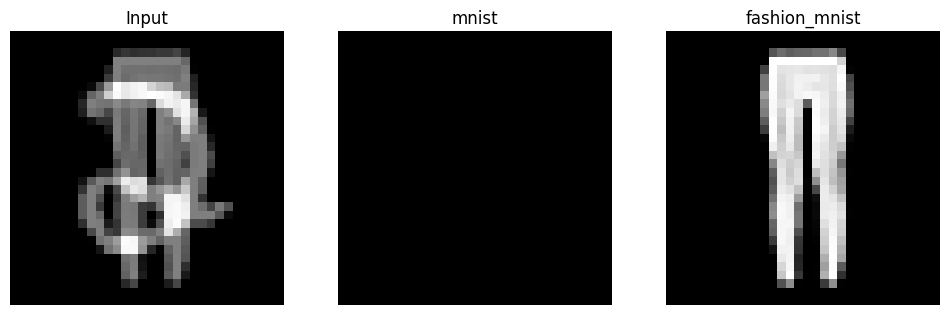



Campione di esempio numero  26


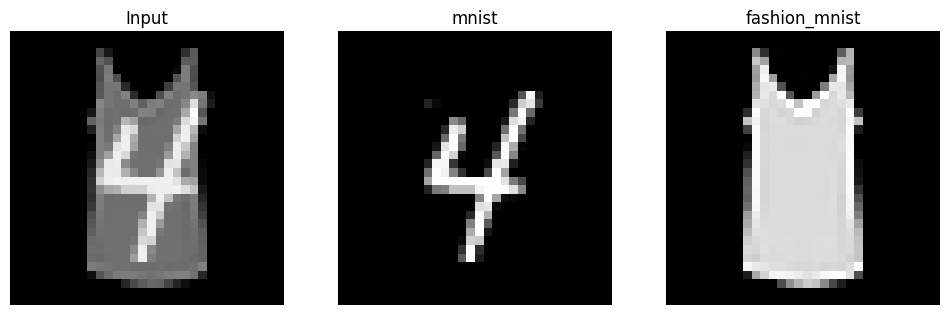

Previsione del modello banale


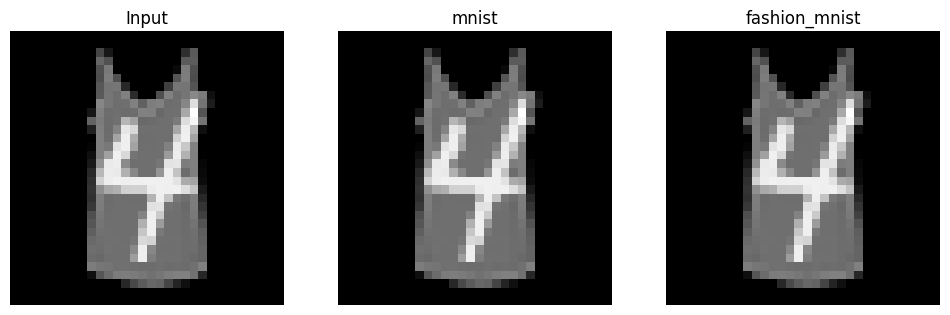

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


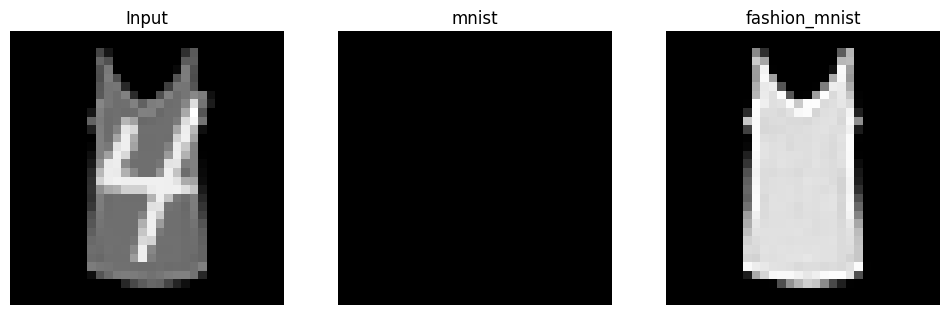



Campione di esempio numero  27


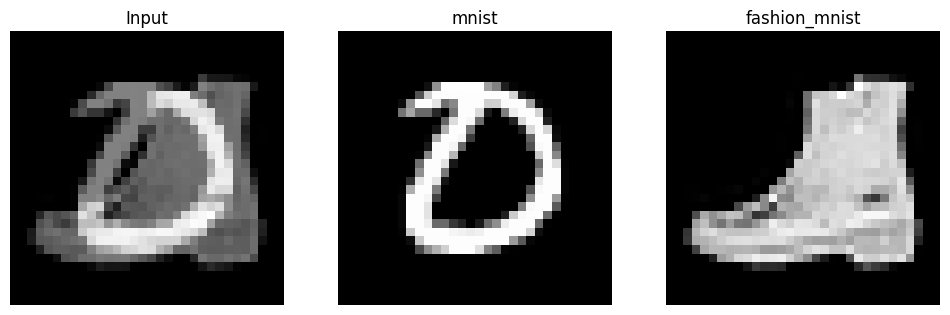

Previsione del modello banale


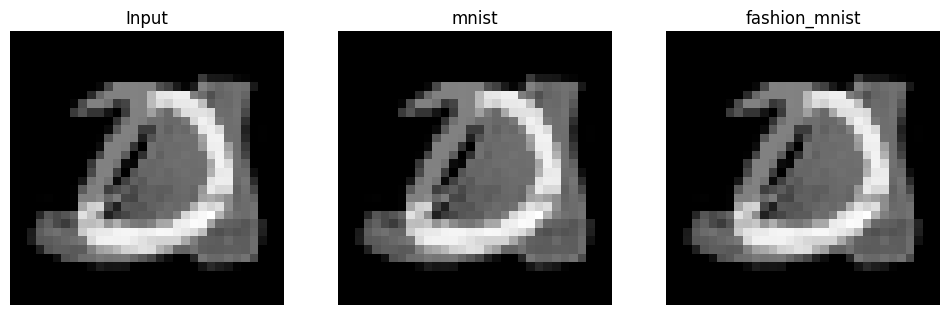

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


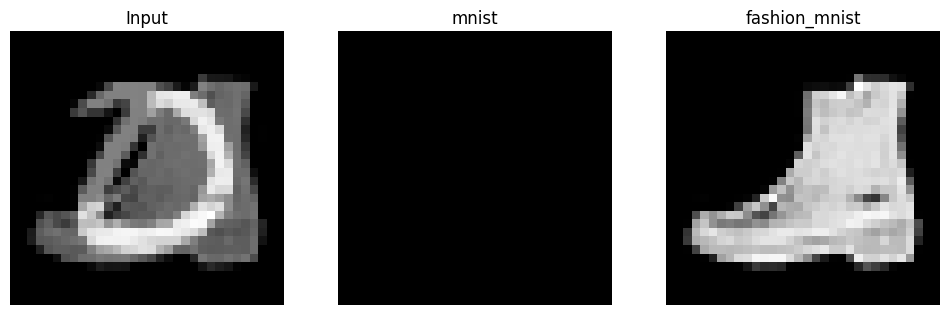



Campione di esempio numero  28


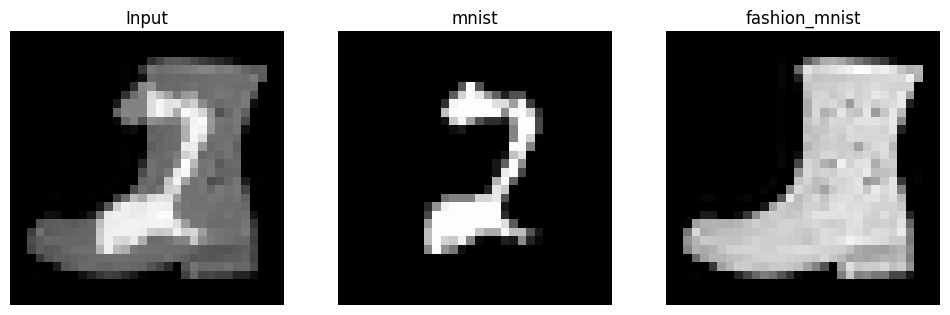

Previsione del modello banale


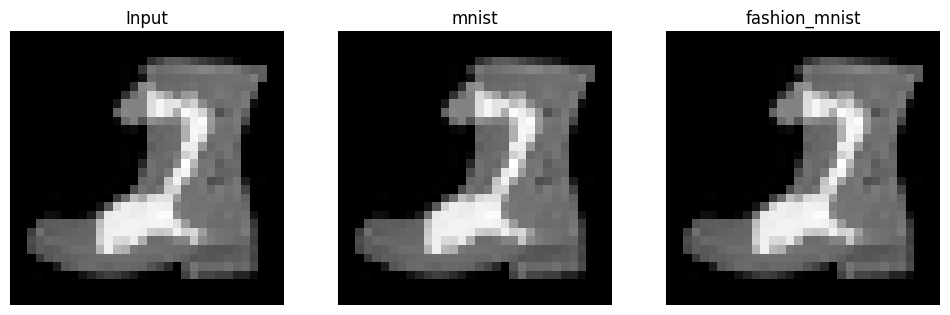

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


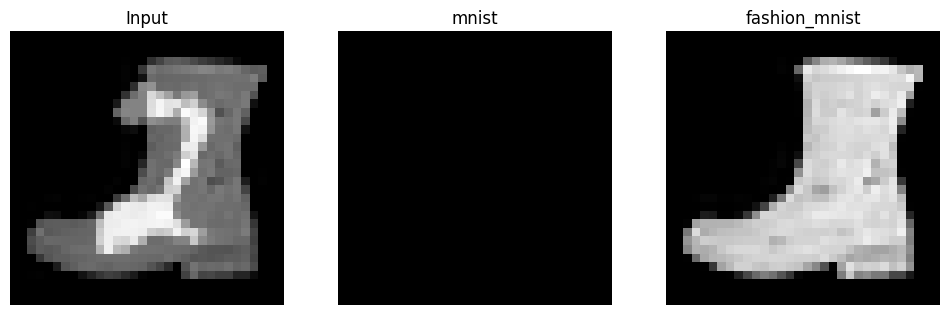



Campione di esempio numero  29


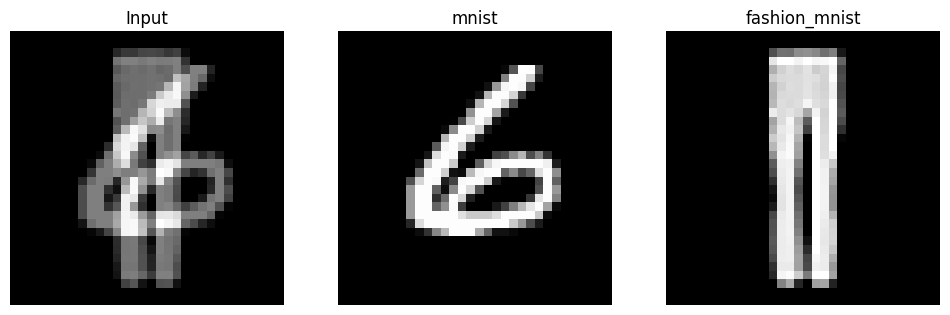

Previsione del modello banale


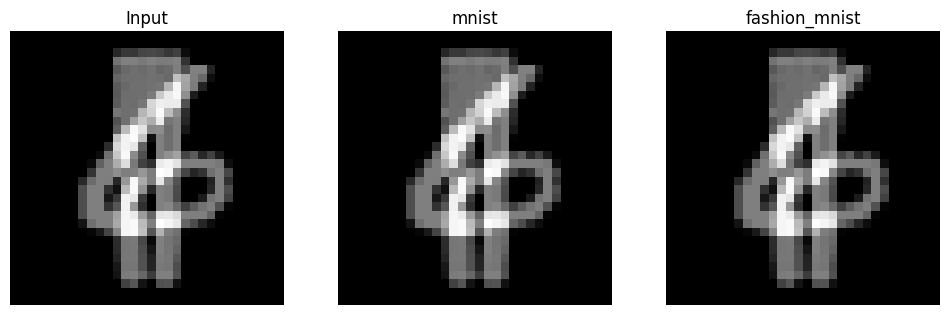

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


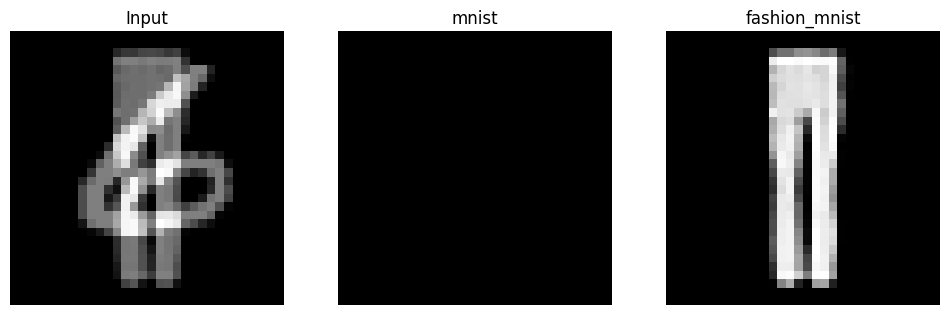

In [34]:
onegen = datagenerator(mnist_x_test, fashion_mnist_x_test, 1)

def show_images(x, y1, y2):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

for i in range(1, 30):
  print('Campione di esempio numero ', i)
  x, (y1, y2) = next(onegen)
  show_images(x[0], y1[0], y2[0])

  print('Previsione del modello banale')
  y1_pred, y2_pred = ide_model(x)
  show_images(x[0], y1_pred[0], y2_pred[0])

  print('Previsione della rete neurale')
  y1_pred, y2_pred = model.predict(x)
  show_images(x[0], y1_pred[0], y2_pred[0])

  print()
  print()